In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="white", palette="husl")

%load_ext autoreload
%autoreload 2

import numpy as np
import gym
import sys
import os
if "../" not in sys.path:
    sys.path.insert(0, "../")

from algo.lstd import LSTDQ, LSTDMu, LSPI
from algo.policy import RandomPolicy2, LinearQ2
from env.simulator import * 
from util.plotting import *
from util.basis import *
from algo.fa import LinearQ3
from algo.dqn import DQN

from logger import *
setup_logging(default_level=logging.INFO)


/usr/lib64/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
env_id = "MountainCar-v0"
env = gym.envs.make(env_id)

# hack to give us control over the initial state
import types

def new_timelimit_reset(self, s_init=None):
    import time
    self._episode_started_at = time.time()
    self._elapsed_steps = 0
    return self.env.reset(s_init)

def new_reset(self, s_init):
    if s_init is None:
        s_init = [np.random.uniform(-0.6, -0.4), 0]
    self.state = np.array(s_init)
    return np.array(self.state)
env.reset = types.MethodType(new_timelimit_reset, env)
env.env.reset = types.MethodType(new_reset, env.env)


state_dim = env.observation_space.shape[0]
# discrete action
action_dim = 1
n_action = env.action_space.n
action_list = np.arange(3)
sim = Simulator(env, state_dim=state_dim, action_dim=action_dim)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


## Online mode DQN
- mountain car has reward of -1 everywhere and dqn's prediction is likely initialized around zero. It's very optimistic and therefore it will end up exploring as much as possible wherever it did not get -1's. therefore epsilon can be very low.
- the learning rate matters

In [9]:
import tensorflow as tf

# test online dqn
with tf.Graph().as_default():
    dqn = DQN(env,
               D=None,
               hiddens=[128, 64],
               learning_rate=1e-4,
               gamma=0.99,
               buffer_size=50000,
               max_timesteps=10**5,
               print_freq=100,
               layer_norm=True,
               exploration_fraction=0.0001,
               exploration_final_eps=0.0001,
               param_noise=True,
               grad_norm_clipping=10,
               buffer_batch_size=32)


In [10]:
with tf.Graph().as_default():
    dqn.train(use_batch=False)

/usr/local/lib64/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib64/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


--------------------------------------
| % time spent exploring  | 0        |
| episodes                | 30       |
| mean 100 episode reward | -200     |
| steps                   | 5799     |
--------------------------------------
--------------------------------------
| % time spent exploring  | 0        |
| episodes                | 60       |
| mean 100 episode reward | -199     |
| steps                   | 11734    |
--------------------------------------
--------------------------------------
| % time spent exploring  | 0        |
| episodes                | 90       |
| mean 100 episode reward | -197     |
| steps                   | 17520    |
--------------------------------------
Saving model due to mean reward increase: None -> -197.2
--------------------------------------
| % time spent exploring  | 0        |
| episodes                | 120      |
| mean 100 episode reward | -196     |
| steps                   | 23353    |
--------------------------------------
-------

INFO:tensorflow:Restoring parameters from /tmp/tmpvwzwhii1/model


Saving model to mountaincar_model.pkl


In [ ]:
# PERcheck ?


## Batch mode DQN
- generate three types of D

In [3]:
class NearExpertPolicy():
    """
    hard-coded near-optimal expert policy
    for mountaincar-v0
    """
    def choose_action(self, s):
        pos, v = s
        c = 0
        #c = np.random.uniform(-0.1, 0.1)
        return 0 if v <= c else 2

class OppositeNearExpertPolicy():
    """
    hard-coded near-optimal expert policy
    for mountaincar-v0
    """
    def choose_action(self, s):
        pos, v = s
        c = np.random.uniform(-0.2, 0.2)
        return 0 if v > c else 2
    
pi_near = NearExpertPolicy()
pi_near_ops = OppositeNearExpertPolicy()
pi_random = RandomPolicy2(action_list)
pi_expert = pi_near

# mixed training set
pi_list = [pi_random, pi_near_ops, pi_near]
mix_ratio = [0.5, 0.1, 0.4]

D_mixed_size = 100
D_mixed = sim.simulate_mixed(env, pi_list, D_mixed_size, mix_ratio)
D_mixed_mat = Simulator.to_matrix(D_mixed)

# pure expert
D_pure_size = 30
D_pure = sim.simulate(pi_expert, 1, D_pure_size)
D_pure_mat = Simulator.to_matrix(D_pure)

def generate_state_samples(env, pi, n_sample=1000):
    """
    a hacky way to cover most state space uniformly
    """
    D = []
    states=np.array([env.observation_space.sample() for _ in range(n_sample)])
    for s in states:
        env.reset(s)
        a = pi.choose_action(s)
        s_next, r, done, _ = env.step(a)
        # one transition = one episode
        absorb = s_next[0] > 0.5 or s[0] > 0.5
        D.append([[s, a, r, s_next, absorb, done]])
    return D

D_fake_size = 3000
D_fake = generate_state_samples(env, pi_random, D_fake_size)
D_fake_mat = Simulator.to_matrix(D_fake)

Step 152 @ Episode 30/30 (-164.0)

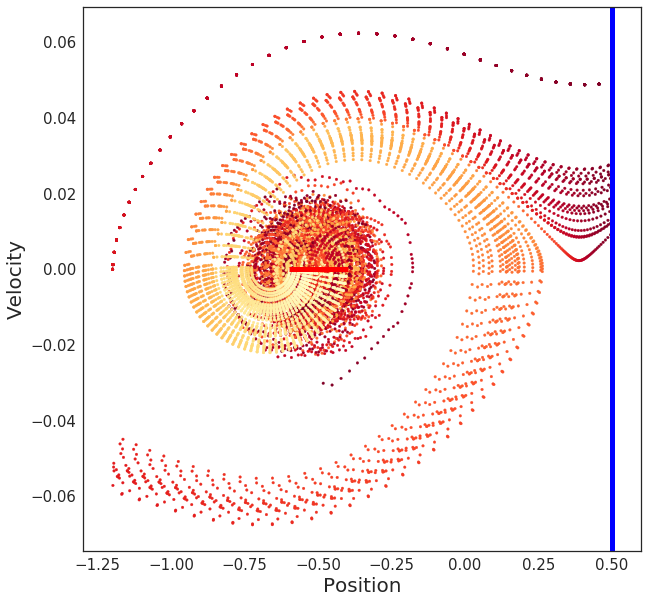

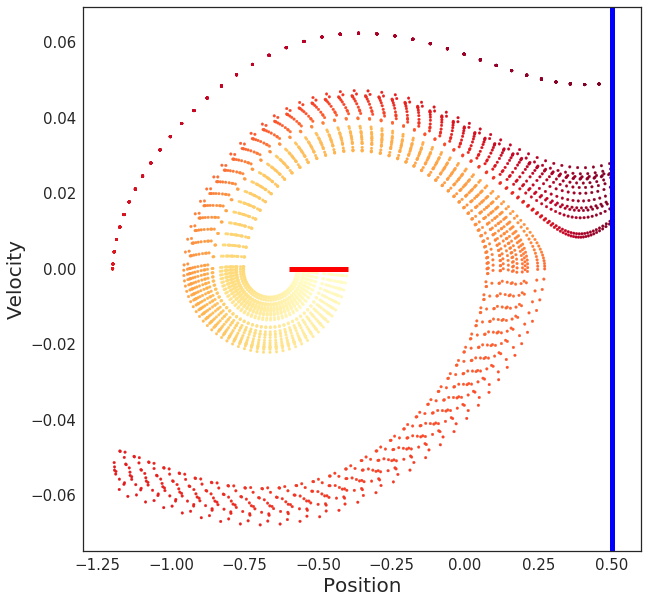

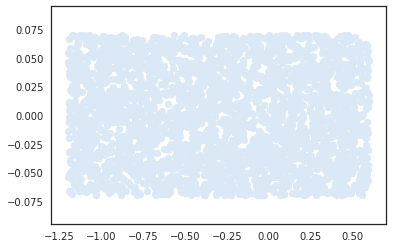

In [4]:
plot_trajectory_mountain_car(D_mixed)
plot_trajectory_mountain_car(D_pure)
synthetic=np.array([env.observation_space.sample() for _ in range(D_fake_size)])
plt.scatter(synthetic[:, 0], synthetic[:, 1])

## train with fake data

In [ ]:
import tensorflow as tf
# use PER
# test online dqn
with tf.Graph().as_default():
    dqn = DQN(env,
               D=D_mixed_mat,
               hiddens=[128, 64],
               learning_rate=1e-4,
               gamma=0.99,
               buffer_size=50000,
               max_timesteps=10**5,
               print_freq=100,
               layer_norm=True,
               exploration_fraction=0.0001,
               exploration_final_eps=0.0001,
               policy_evaluate_freq=1000,
               param_noise=True,
               grad_norm_clipping=10,
               buffer_batch_size=32)


INFO:root:dumping D of size (17036, 6) into experience replay


In [ ]:
with tf.Graph().as_default():
    dqn.train(use_batch=True)

INFO:root:been trained 0 steps
INFO:root:been trained 500 steps
INFO:root:been trained 1000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1500 steps
INFO:root:been trained 2000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2500 steps
INFO:root:been trained 3000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 3500 steps
INFO:root:been trained 4000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 4500 steps
INFO:root:been trained 5000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 5500 steps
INFO:root:been trained 6000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 6500 steps
INFO:root:been trained 7000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 7500 steps
INFO:root:been trained 8000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 8500 steps
INFO:root:been trained 9000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 9500 steps
INFO:root:been trained 10000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 10500 steps
INFO:root:been trained 11000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 11500 steps
INFO:root:been trained 12000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 12500 steps
INFO:root:been trained 13000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 13500 steps
INFO:root:been trained 14000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 14500 steps
INFO:root:been trained 15000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 15500 steps
INFO:root:been trained 16000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 16500 steps
INFO:root:been trained 17000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 17500 steps
INFO:root:been trained 18000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -155     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 18500 steps
INFO:root:been trained 19000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -158     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 19500 steps
INFO:root:been trained 20000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -198     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 20500 steps
INFO:root:been trained 21000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 21500 steps
INFO:root:been trained 22000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 22500 steps
INFO:root:been trained 23000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -198     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 23500 steps
INFO:root:been trained 24000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 24500 steps
INFO:root:been trained 25000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -147     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 25500 steps
INFO:root:been trained 26000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -155     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 26500 steps
INFO:root:been trained 27000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -144     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 27500 steps
INFO:root:been trained 28000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -153     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 28500 steps
INFO:root:been trained 29000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -193     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 29500 steps
INFO:root:been trained 30000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 19       |
| mean episode reward    | -166     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 30500 steps
INFO:root:been trained 31000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 19       |
| mean episode reward    | -167     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 31500 steps
INFO:root:been trained 32000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 19       |
| mean episode reward    | -165     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 32500 steps
INFO:root:been trained 33000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 18       |
| mean episode reward    | -167     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 33500 steps
INFO:root:been trained 34000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 18       |
| mean episode reward    | -169     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 34500 steps
INFO:root:been trained 35000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -191     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 35500 steps
INFO:root:been trained 36000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -193     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 36500 steps
INFO:root:been trained 37000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 37500 steps
INFO:root:been trained 38000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -190     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 38500 steps
INFO:root:been trained 39000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -189     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 39500 steps
INFO:root:been trained 40000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -191     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 40500 steps
INFO:root:been trained 41000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -194     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 41500 steps
INFO:root:been trained 42000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 42500 steps
INFO:root:been trained 43000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 17       |
| mean episode reward    | -187     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 43500 steps
INFO:root:been trained 44000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 19       |
| mean episode reward    | -166     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 44500 steps
INFO:root:been trained 45000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 19       |
| mean episode reward    | -159     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 45500 steps
INFO:root:been trained 46000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -156     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 46500 steps
INFO:root:been trained 47000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -157     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 47500 steps
INFO:root:been trained 48000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -155     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 48500 steps
INFO:root:been trained 49000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -149     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 49500 steps
INFO:root:been trained 50000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -156     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 50500 steps
INFO:root:been trained 51000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 19       |
| mean episode reward    | -161     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 51500 steps
INFO:root:been trained 52000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 19       |
| mean episode reward    | -159     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 52500 steps
INFO:root:been trained 53000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -156     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 53500 steps
INFO:root:been trained 54000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 19       |
| mean episode reward    | -166     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 54500 steps
INFO:root:been trained 55000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 19       |
| mean episode reward    | -160     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 55500 steps
INFO:root:been trained 56000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 18       |
| mean episode reward    | -172     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 56500 steps
INFO:root:been trained 57000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 18       |
| mean episode reward    | -172     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 57500 steps
INFO:root:been trained 58000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 18       |
| mean episode reward    | -173     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 58500 steps
INFO:root:been trained 59000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -190     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 59500 steps
INFO:root:been trained 60000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -189     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 60500 steps
INFO:root:been trained 61000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -188     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 61500 steps
INFO:root:been trained 62000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 17       |
| mean episode reward    | -183     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 62500 steps
INFO:root:been trained 63000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 17       |
| mean episode reward    | -178     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 63500 steps
INFO:root:been trained 64000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 17       |
| mean episode reward    | -188     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 64500 steps
INFO:root:been trained 65000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -188     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 65500 steps
INFO:root:been trained 66000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 17       |
| mean episode reward    | -182     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 66500 steps
INFO:root:been trained 67000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 67500 steps
INFO:root:been trained 68000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 68500 steps
INFO:root:been trained 69000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 69500 steps
INFO:root:been trained 70000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 70500 steps
INFO:root:been trained 71000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 71500 steps
INFO:root:been trained 72000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 72500 steps
INFO:root:been trained 73000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 73500 steps
INFO:root:been trained 74000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 74500 steps
INFO:root:been trained 75000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 75500 steps
INFO:root:been trained 76000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 76500 steps
INFO:root:been trained 77000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 77500 steps
INFO:root:been trained 78000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 78500 steps
INFO:root:been trained 79000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 79500 steps
INFO:root:been trained 80000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 80500 steps
INFO:root:been trained 81000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 81500 steps
INFO:root:been trained 82000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 82500 steps
INFO:root:been trained 83000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 83500 steps
INFO:root:been trained 84000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 84500 steps
INFO:root:been trained 85000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 17       |
| mean episode reward    | -181     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 85500 steps
INFO:root:been trained 86000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -137     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 86500 steps
INFO:root:been trained 87000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -138     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 87500 steps
INFO:root:been trained 88000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -126     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 88500 steps
INFO:root:been trained 89000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 89500 steps
INFO:root:been trained 90000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -134     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 90500 steps
INFO:root:been trained 91000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -125     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 91500 steps
INFO:root:been trained 92000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 92500 steps
INFO:root:been trained 93000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -140     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 93500 steps
INFO:root:been trained 94000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 94500 steps
INFO:root:been trained 95000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 95500 steps
INFO:root:been trained 96000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 96500 steps
INFO:root:been trained 97000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 97500 steps
INFO:root:been trained 98000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 98500 steps
INFO:root:been trained 99000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 99500 steps
INFO:root:been trained 100000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -147     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 100500 steps
INFO:root:been trained 101000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 19       |
| mean episode reward    | -156     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 101500 steps
INFO:root:been trained 102000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 18       |
| mean episode reward    | -167     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 102500 steps
INFO:root:been trained 103000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -148     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 103500 steps
INFO:root:been trained 104000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -154     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 104500 steps
INFO:root:been trained 105000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 17       |
| mean episode reward    | -180     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 105500 steps
INFO:root:been trained 106000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 106500 steps
INFO:root:been trained 107000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 18       |
| mean episode reward    | -174     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 107500 steps
INFO:root:been trained 108000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 108500 steps
INFO:root:been trained 109000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -146     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 109500 steps
INFO:root:been trained 110000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -148     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 110500 steps
INFO:root:been trained 111000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 17       |
| mean episode reward    | -183     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 111500 steps
INFO:root:been trained 112000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 112500 steps
INFO:root:been trained 113000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 113500 steps
INFO:root:been trained 114000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 114500 steps
INFO:root:been trained 115000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 17       |
| mean episode reward    | -186     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 115500 steps
INFO:root:been trained 116000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -188     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 116500 steps
INFO:root:been trained 117000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -198     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 117500 steps
INFO:root:been trained 118000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 118500 steps
INFO:root:been trained 119000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -198     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 119500 steps
INFO:root:been trained 120000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 120500 steps
INFO:root:been trained 121000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 17       |
| mean episode reward    | -185     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 121500 steps
INFO:root:been trained 122000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 17       |
| mean episode reward    | -186     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 122500 steps
INFO:root:been trained 123000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 17       |
| mean episode reward    | -186     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 123500 steps
INFO:root:been trained 124000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 19       |
| mean episode reward    | -166     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 124500 steps
INFO:root:been trained 125000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -158     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 125500 steps
INFO:root:been trained 126000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 126500 steps
INFO:root:been trained 127000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 127500 steps
INFO:root:been trained 128000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 128500 steps
INFO:root:been trained 129000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 17       |
| mean episode reward    | -184     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 129500 steps
INFO:root:been trained 130000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 19       |
| mean episode reward    | -162     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 130500 steps
INFO:root:been trained 131000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -157     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 131500 steps
INFO:root:been trained 132000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 17       |
| mean episode reward    | -186     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 132500 steps
INFO:root:been trained 133000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 133500 steps
INFO:root:been trained 134000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 134500 steps
INFO:root:been trained 135000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -197     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 135500 steps
INFO:root:been trained 136000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 136500 steps
INFO:root:been trained 137000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 17       |
| mean episode reward    | -183     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 137500 steps
INFO:root:been trained 138000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 138500 steps
INFO:root:been trained 139000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -197     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 139500 steps
INFO:root:been trained 140000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 140500 steps
INFO:root:been trained 141000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 19       |
| mean episode reward    | -162     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 141500 steps
INFO:root:been trained 142000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 18       |
| mean episode reward    | -167     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 142500 steps
INFO:root:been trained 143000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 19       |
| mean episode reward    | -161     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 143500 steps
INFO:root:been trained 144000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 19       |
| mean episode reward    | -165     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 144500 steps
INFO:root:been trained 145000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -154     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 145500 steps
INFO:root:been trained 146000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -144     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 146500 steps
INFO:root:been trained 147000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -141     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 147500 steps
INFO:root:been trained 148000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -148     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 148500 steps
INFO:root:been trained 149000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 18       |
| mean episode reward    | -171     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 149500 steps
INFO:root:been trained 150000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -194     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 150500 steps
INFO:root:been trained 151000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -193     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 151500 steps
INFO:root:been trained 152000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 152500 steps
INFO:root:been trained 153000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 153500 steps
INFO:root:been trained 154000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 154500 steps
INFO:root:been trained 155000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 155500 steps
INFO:root:been trained 156000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 156500 steps
INFO:root:been trained 157000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -142     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 157500 steps
INFO:root:been trained 158000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -142     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 158500 steps
INFO:root:been trained 159000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 18       |
| mean episode reward    | -176     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 159500 steps
INFO:root:been trained 160000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -127     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 160500 steps
INFO:root:been trained 161000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -156     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 161500 steps
INFO:root:been trained 162000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 19       |
| mean episode reward    | -162     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 162500 steps
INFO:root:been trained 163000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -147     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 163500 steps
INFO:root:been trained 164000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -151     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 164500 steps
INFO:root:been trained 165000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 165500 steps
INFO:root:been trained 166000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 17       |
| mean episode reward    | -187     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 166500 steps
INFO:root:been trained 167000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 17       |
| mean episode reward    | -176     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 167500 steps
INFO:root:been trained 168000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -198     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 168500 steps
INFO:root:been trained 169000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 18       |
| mean episode reward    | -171     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 169500 steps
INFO:root:been trained 170000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -145     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 170500 steps
INFO:root:been trained 171000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -136     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 171500 steps
INFO:root:been trained 172000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -137     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 172500 steps
INFO:root:been trained 173000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -129     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 173500 steps
INFO:root:been trained 174000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -133     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 174500 steps
INFO:root:been trained 175000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -139     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 175500 steps
INFO:root:been trained 176000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -143     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 176500 steps
INFO:root:been trained 177000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -155     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 177500 steps
INFO:root:been trained 178000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -188     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 178500 steps
INFO:root:been trained 179000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -149     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 179500 steps
INFO:root:been trained 180000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -187     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 180500 steps
INFO:root:been trained 181000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 18       |
| mean episode reward    | -175     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 181500 steps
INFO:root:been trained 182000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 17       |
| mean episode reward    | -178     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 182500 steps
INFO:root:been trained 183000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 18       |
| mean episode reward    | -167     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 183500 steps
INFO:root:been trained 184000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 19       |
| mean episode reward    | -161     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 184500 steps
INFO:root:been trained 185000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 19       |
| mean episode reward    | -162     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 185500 steps
INFO:root:been trained 186000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -157     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 186500 steps
INFO:root:been trained 187000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -156     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 187500 steps
INFO:root:been trained 188000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -139     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 188500 steps
INFO:root:been trained 189000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -190     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 189500 steps
INFO:root:been trained 190000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -198     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 190500 steps
INFO:root:been trained 191000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -152     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 191500 steps
INFO:root:been trained 192000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -150     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 192500 steps
INFO:root:been trained 193000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -149     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 193500 steps
INFO:root:been trained 194000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -144     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 194500 steps
INFO:root:been trained 195000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -139     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 195500 steps
INFO:root:been trained 196000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -146     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 196500 steps
INFO:root:been trained 197000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -143     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 197500 steps
INFO:root:been trained 198000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 18       |
| mean episode reward    | -168     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 198500 steps
INFO:root:been trained 199000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -196     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 199500 steps
INFO:root:been trained 200000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 200500 steps
INFO:root:been trained 201000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 201500 steps
INFO:root:been trained 202000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 202500 steps
INFO:root:been trained 203000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 203500 steps
INFO:root:been trained 204000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 204500 steps
INFO:root:been trained 205000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 205500 steps
INFO:root:been trained 206000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 19       |
| mean episode reward    | -166     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 206500 steps
INFO:root:been trained 207000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 19       |
| mean episode reward    | -157     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 207500 steps
INFO:root:been trained 208000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -141     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 208500 steps
INFO:root:been trained 209000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -135     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 209500 steps
INFO:root:been trained 210000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -121     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 210500 steps
INFO:root:been trained 211000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 211500 steps
INFO:root:been trained 212000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 212500 steps
INFO:root:been trained 213000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -102     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 213500 steps
INFO:root:been trained 214000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -134     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 214500 steps
INFO:root:been trained 215000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -118     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 215500 steps
INFO:root:been trained 216000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -122     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 216500 steps
INFO:root:been trained 217000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -136     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 217500 steps
INFO:root:been trained 218000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -146     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 218500 steps
INFO:root:been trained 219000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -140     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 219500 steps
INFO:root:been trained 220000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -134     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 220500 steps
INFO:root:been trained 221000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -136     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 221500 steps
INFO:root:been trained 222000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -142     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 222500 steps
INFO:root:been trained 223000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -138     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 223500 steps
INFO:root:been trained 224000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -127     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 224500 steps
INFO:root:been trained 225000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -134     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 225500 steps
INFO:root:been trained 226000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 226500 steps
INFO:root:been trained 227000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -121     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 227500 steps
INFO:root:been trained 228000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -119     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 228500 steps
INFO:root:been trained 229000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -134     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 229500 steps
INFO:root:been trained 230000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -119     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 230500 steps
INFO:root:been trained 231000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -128     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 231500 steps
INFO:root:been trained 232000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -138     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 232500 steps
INFO:root:been trained 233000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -137     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 233500 steps
INFO:root:been trained 234000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -138     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 234500 steps
INFO:root:been trained 235000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -136     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 235500 steps
INFO:root:been trained 236000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -144     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 236500 steps
INFO:root:been trained 237000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -136     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 237500 steps
INFO:root:been trained 238000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -150     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 238500 steps
INFO:root:been trained 239000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 18       |
| mean episode reward    | -170     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 239500 steps
INFO:root:been trained 240000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 19       |
| mean episode reward    | -164     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 240500 steps
INFO:root:been trained 241000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 17       |
| mean episode reward    | -183     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 241500 steps
INFO:root:been trained 242000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -155     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 242500 steps
INFO:root:been trained 243000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -123     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 243500 steps
INFO:root:been trained 244000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -124     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 244500 steps
INFO:root:been trained 245000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -130     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 245500 steps
INFO:root:been trained 246000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -136     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 246500 steps
INFO:root:been trained 247000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -136     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 247500 steps
INFO:root:been trained 248000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -143     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 248500 steps
INFO:root:been trained 249000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -147     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 249500 steps
INFO:root:been trained 250000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -135     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 250500 steps
INFO:root:been trained 251000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 19       |
| mean episode reward    | -167     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 251500 steps
INFO:root:been trained 252000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -136     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 252500 steps
INFO:root:been trained 253000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -142     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 253500 steps
INFO:root:been trained 254000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -148     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 254500 steps
INFO:root:been trained 255000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -145     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 255500 steps
INFO:root:been trained 256000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -138     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 256500 steps
INFO:root:been trained 257000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -134     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 257500 steps
INFO:root:been trained 258000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -153     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 258500 steps
INFO:root:been trained 259000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -137     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 259500 steps
INFO:root:been trained 260000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 19       |
| mean episode reward    | -157     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 260500 steps
INFO:root:been trained 261000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -141     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 261500 steps
INFO:root:been trained 262000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -140     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 262500 steps
INFO:root:been trained 263000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -158     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 263500 steps
INFO:root:been trained 264000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -122     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 264500 steps
INFO:root:been trained 265000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -117     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 265500 steps
INFO:root:been trained 266000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -142     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 266500 steps
INFO:root:been trained 267000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -130     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 267500 steps
INFO:root:been trained 268000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -130     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 268500 steps
INFO:root:been trained 269000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -122     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 269500 steps
INFO:root:been trained 270000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -133     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 270500 steps
INFO:root:been trained 271000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -133     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 271500 steps
INFO:root:been trained 272000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -138     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 272500 steps
INFO:root:been trained 273000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -127     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 273500 steps
INFO:root:been trained 274000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -134     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 274500 steps
INFO:root:been trained 275000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -128     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 275500 steps
INFO:root:been trained 276000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -129     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 276500 steps
INFO:root:been trained 277000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -128     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 277500 steps
INFO:root:been trained 278000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -129     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 278500 steps
INFO:root:been trained 279000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -135     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 279500 steps
INFO:root:been trained 280000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 31       |
| mean episode reward    | -98.6    |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 280500 steps
INFO:root:been trained 281000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -111     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 281500 steps
INFO:root:been trained 282000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -109     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 282500 steps
INFO:root:been trained 283000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -104     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 283500 steps
INFO:root:been trained 284000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -102     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 284500 steps
INFO:root:been trained 285000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 31       |
| mean episode reward    | -98.6    |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 285500 steps
INFO:root:been trained 286000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -109     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 286500 steps
INFO:root:been trained 287000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -106     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 287500 steps
INFO:root:been trained 288000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -104     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 288500 steps
INFO:root:been trained 289000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 289500 steps
INFO:root:been trained 290000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -100     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 290500 steps
INFO:root:been trained 291000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -111     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 291500 steps
INFO:root:been trained 292000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -103     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 292500 steps
INFO:root:been trained 293000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -113     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 293500 steps
INFO:root:been trained 294000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 294500 steps
INFO:root:been trained 295000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -117     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 295500 steps
INFO:root:been trained 296000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -115     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 296500 steps
INFO:root:been trained 297000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 297500 steps
INFO:root:been trained 298000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 298500 steps
INFO:root:been trained 299000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 299500 steps
INFO:root:been trained 300000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -113     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 300500 steps
INFO:root:been trained 301000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -122     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 301500 steps
INFO:root:been trained 302000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -109     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 302500 steps
INFO:root:been trained 303000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -120     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 303500 steps
INFO:root:been trained 304000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 304500 steps
INFO:root:been trained 305000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 305500 steps
INFO:root:been trained 306000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -127     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 306500 steps
INFO:root:been trained 307000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -117     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 307500 steps
INFO:root:been trained 308000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -125     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 308500 steps
INFO:root:been trained 309000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -128     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 309500 steps
INFO:root:been trained 310000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -120     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 310500 steps
INFO:root:been trained 311000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -123     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 311500 steps
INFO:root:been trained 312000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -124     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 312500 steps
INFO:root:been trained 313000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 313500 steps
INFO:root:been trained 314000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 314500 steps
INFO:root:been trained 315000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -106     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 315500 steps
INFO:root:been trained 316000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -122     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 316500 steps
INFO:root:been trained 317000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 317500 steps
INFO:root:been trained 318000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -111     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 318500 steps
INFO:root:been trained 319000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -115     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 319500 steps
INFO:root:been trained 320000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -117     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 320500 steps
INFO:root:been trained 321000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 321500 steps
INFO:root:been trained 322000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -119     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 322500 steps
INFO:root:been trained 323000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -127     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 323500 steps
INFO:root:been trained 324000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -109     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 324500 steps
INFO:root:been trained 325000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -124     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 325500 steps
INFO:root:been trained 326000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -116     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 326500 steps
INFO:root:been trained 327000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -117     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 327500 steps
INFO:root:been trained 328000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -117     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 328500 steps
INFO:root:been trained 329000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 329500 steps
INFO:root:been trained 330000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -111     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 330500 steps
INFO:root:been trained 331000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -113     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 331500 steps
INFO:root:been trained 332000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 332500 steps
INFO:root:been trained 333000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -119     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 333500 steps
INFO:root:been trained 334000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -126     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 334500 steps
INFO:root:been trained 335000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -120     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 335500 steps
INFO:root:been trained 336000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 336500 steps
INFO:root:been trained 337000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 337500 steps
INFO:root:been trained 338000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -113     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 338500 steps
INFO:root:been trained 339000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -111     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 339500 steps
INFO:root:been trained 340000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -121     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 340500 steps
INFO:root:been trained 341000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -116     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 341500 steps
INFO:root:been trained 342000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -130     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 342500 steps
INFO:root:been trained 343000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -125     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 343500 steps
INFO:root:been trained 344000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -116     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 344500 steps
INFO:root:been trained 345000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -117     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 345500 steps
INFO:root:been trained 346000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -128     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 346500 steps
INFO:root:been trained 347000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -132     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 347500 steps
INFO:root:been trained 348000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -141     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 348500 steps
INFO:root:been trained 349000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -146     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 349500 steps
INFO:root:been trained 350000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -147     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 350500 steps
INFO:root:been trained 351000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 351500 steps
INFO:root:been trained 352000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 352500 steps
INFO:root:been trained 353000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 353500 steps
INFO:root:been trained 354000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -134     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 354500 steps
INFO:root:been trained 355000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -115     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 355500 steps
INFO:root:been trained 356000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -113     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 356500 steps
INFO:root:been trained 357000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -132     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 357500 steps
INFO:root:been trained 358000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -152     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 358500 steps
INFO:root:been trained 359000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -128     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 359500 steps
INFO:root:been trained 360000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 360500 steps
INFO:root:been trained 361000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -131     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 361500 steps
INFO:root:been trained 362000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -131     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 362500 steps
INFO:root:been trained 363000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 363500 steps
INFO:root:been trained 364000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -113     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 364500 steps
INFO:root:been trained 365000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -113     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 365500 steps
INFO:root:been trained 366000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 366500 steps
INFO:root:been trained 367000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -113     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 367500 steps
INFO:root:been trained 368000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 368500 steps
INFO:root:been trained 369000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -120     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 369500 steps
INFO:root:been trained 370000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 370500 steps
INFO:root:been trained 371000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -113     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 371500 steps
INFO:root:been trained 372000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 372500 steps
INFO:root:been trained 373000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -118     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 373500 steps
INFO:root:been trained 374000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -124     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 374500 steps
INFO:root:been trained 375000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 375500 steps
INFO:root:been trained 376000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -118     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 376500 steps
INFO:root:been trained 377000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -115     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 377500 steps
INFO:root:been trained 378000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -122     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 378500 steps
INFO:root:been trained 379000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -126     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 379500 steps
INFO:root:been trained 380000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 380500 steps
INFO:root:been trained 381000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -124     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 381500 steps
INFO:root:been trained 382000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -125     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 382500 steps
INFO:root:been trained 383000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -124     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 383500 steps
INFO:root:been trained 384000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -119     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 384500 steps
INFO:root:been trained 385000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -116     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 385500 steps
INFO:root:been trained 386000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 386500 steps
INFO:root:been trained 387000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 387500 steps
INFO:root:been trained 388000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -121     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 388500 steps
INFO:root:been trained 389000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 389500 steps
INFO:root:been trained 390000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 390500 steps
INFO:root:been trained 391000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -122     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 391500 steps
INFO:root:been trained 392000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -119     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 392500 steps
INFO:root:been trained 393000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -128     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 393500 steps
INFO:root:been trained 394000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -116     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 394500 steps
INFO:root:been trained 395000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -115     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 395500 steps
INFO:root:been trained 396000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 396500 steps
INFO:root:been trained 397000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -115     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 397500 steps
INFO:root:been trained 398000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -146     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 398500 steps
INFO:root:been trained 399000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -145     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 399500 steps
INFO:root:been trained 400000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -140     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 400500 steps
INFO:root:been trained 401000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -133     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 401500 steps
INFO:root:been trained 402000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -136     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 402500 steps
INFO:root:been trained 403000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -136     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 403500 steps
INFO:root:been trained 404000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -130     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 404500 steps
INFO:root:been trained 405000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -123     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 405500 steps
INFO:root:been trained 406000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -127     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 406500 steps
INFO:root:been trained 407000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -121     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 407500 steps
INFO:root:been trained 408000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -119     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 408500 steps
INFO:root:been trained 409000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -124     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 409500 steps
INFO:root:been trained 410000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -135     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 410500 steps
INFO:root:been trained 411000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -123     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 411500 steps
INFO:root:been trained 412000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -124     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 412500 steps
INFO:root:been trained 413000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -130     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 413500 steps
INFO:root:been trained 414000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -125     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 414500 steps
INFO:root:been trained 415000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -118     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 415500 steps
INFO:root:been trained 416000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 416500 steps
INFO:root:been trained 417000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -111     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 417500 steps
INFO:root:been trained 418000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 418500 steps
INFO:root:been trained 419000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -116     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 419500 steps
INFO:root:been trained 420000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -128     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 420500 steps
INFO:root:been trained 421000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -118     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 421500 steps
INFO:root:been trained 422000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 422500 steps
INFO:root:been trained 423000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -111     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 423500 steps
INFO:root:been trained 424000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -121     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 424500 steps
INFO:root:been trained 425000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -122     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 425500 steps
INFO:root:been trained 426000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -111     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 426500 steps
INFO:root:been trained 427000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 427500 steps
INFO:root:been trained 428000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -119     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 428500 steps
INFO:root:been trained 429000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -118     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 429500 steps
INFO:root:been trained 430000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -125     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 430500 steps
INFO:root:been trained 431000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -142     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 431500 steps
INFO:root:been trained 432000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -143     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 432500 steps
INFO:root:been trained 433000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -138     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 433500 steps
INFO:root:been trained 434000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -144     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 434500 steps
INFO:root:been trained 435000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -134     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 435500 steps
INFO:root:been trained 436000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -134     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 436500 steps
INFO:root:been trained 437000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -141     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 437500 steps
INFO:root:been trained 438000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -137     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 438500 steps
INFO:root:been trained 439000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -144     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 439500 steps
INFO:root:been trained 440000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -140     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 440500 steps
INFO:root:been trained 441000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -152     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 441500 steps
INFO:root:been trained 442000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -187     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 442500 steps
INFO:root:been trained 443000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -193     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 443500 steps
INFO:root:been trained 444000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -130     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 444500 steps
INFO:root:been trained 445000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -130     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 445500 steps
INFO:root:been trained 446000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -134     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 446500 steps
INFO:root:been trained 447000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -128     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 447500 steps
INFO:root:been trained 448000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -135     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 448500 steps
INFO:root:been trained 449000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -146     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 449500 steps
INFO:root:been trained 450000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -134     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 450500 steps
INFO:root:been trained 451000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -122     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 451500 steps
INFO:root:been trained 452000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -150     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 452500 steps
INFO:root:been trained 453000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -156     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 453500 steps
INFO:root:been trained 454000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -134     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 454500 steps
INFO:root:been trained 455000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -134     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 455500 steps
INFO:root:been trained 456000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -143     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 456500 steps
INFO:root:been trained 457000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -142     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 457500 steps
INFO:root:been trained 458000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -149     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 458500 steps
INFO:root:been trained 459000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -156     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 459500 steps
INFO:root:been trained 460000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -149     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 460500 steps
INFO:root:been trained 461000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -155     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 461500 steps
INFO:root:been trained 462000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 19       |
| mean episode reward    | -160     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 462500 steps
INFO:root:been trained 463000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 19       |
| mean episode reward    | -161     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 463500 steps
INFO:root:been trained 464000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -151     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 464500 steps
INFO:root:been trained 465000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -150     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 465500 steps
INFO:root:been trained 466000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -126     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 466500 steps
INFO:root:been trained 467000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -139     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 467500 steps
INFO:root:been trained 468000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -125     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 468500 steps
INFO:root:been trained 469000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -140     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 469500 steps
INFO:root:been trained 470000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -139     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 470500 steps
INFO:root:been trained 471000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -155     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 471500 steps
INFO:root:been trained 472000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -157     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 472500 steps
INFO:root:been trained 473000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 19       |
| mean episode reward    | -158     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 473500 steps
INFO:root:been trained 474000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 474500 steps
INFO:root:been trained 475000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -115     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 475500 steps
INFO:root:been trained 476000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -125     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 476500 steps
INFO:root:been trained 477000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -131     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 477500 steps
INFO:root:been trained 478000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -133     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 478500 steps
INFO:root:been trained 479000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -117     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 479500 steps
INFO:root:been trained 480000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -124     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 480500 steps
INFO:root:been trained 481000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -124     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 481500 steps
INFO:root:been trained 482000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -134     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 482500 steps
INFO:root:been trained 483000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -129     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 483500 steps
INFO:root:been trained 484000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -138     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 484500 steps
INFO:root:been trained 485000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -127     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 485500 steps
INFO:root:been trained 486000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -115     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 486500 steps
INFO:root:been trained 487000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -128     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 487500 steps
INFO:root:been trained 488000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -140     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 488500 steps
INFO:root:been trained 489000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 19       |
| mean episode reward    | -162     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 489500 steps
INFO:root:been trained 490000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 19       |
| mean episode reward    | -160     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 490500 steps
INFO:root:been trained 491000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 19       |
| mean episode reward    | -162     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 491500 steps
INFO:root:been trained 492000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -140     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 492500 steps
INFO:root:been trained 493000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -148     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 493500 steps
INFO:root:been trained 494000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -148     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 494500 steps
INFO:root:been trained 495000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -143     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 495500 steps
INFO:root:been trained 496000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -140     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 496500 steps
INFO:root:been trained 497000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -136     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 497500 steps
INFO:root:been trained 498000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -126     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 498500 steps
INFO:root:been trained 499000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -142     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 499500 steps
INFO:root:been trained 500000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -131     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 500500 steps
INFO:root:been trained 501000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -116     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 501500 steps
INFO:root:been trained 502000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -120     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 502500 steps
INFO:root:been trained 503000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -118     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 503500 steps
INFO:root:been trained 504000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -118     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 504500 steps
INFO:root:been trained 505000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -152     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 505500 steps
INFO:root:been trained 506000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -123     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 506500 steps
INFO:root:been trained 507000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -136     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 507500 steps
INFO:root:been trained 508000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -113     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 508500 steps
INFO:root:been trained 509000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -104     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 509500 steps
INFO:root:been trained 510000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -113     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 510500 steps
INFO:root:been trained 511000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -104     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 511500 steps
INFO:root:been trained 512000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -106     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 512500 steps
INFO:root:been trained 513000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -118     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 513500 steps
INFO:root:been trained 514000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -113     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 514500 steps
INFO:root:been trained 515000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 515500 steps
INFO:root:been trained 516000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -111     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 516500 steps
INFO:root:been trained 517000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -119     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 517500 steps
INFO:root:been trained 518000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -124     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 518500 steps
INFO:root:been trained 519000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -126     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 519500 steps
INFO:root:been trained 520000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -129     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 520500 steps
INFO:root:been trained 521000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 19       |
| mean episode reward    | -163     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 521500 steps
INFO:root:been trained 522000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -155     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 522500 steps
INFO:root:been trained 523000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -138     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 523500 steps
INFO:root:been trained 524000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -129     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 524500 steps
INFO:root:been trained 525000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -129     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 525500 steps
INFO:root:been trained 526000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -134     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 526500 steps
INFO:root:been trained 527000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -117     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 527500 steps
INFO:root:been trained 528000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -124     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 528500 steps
INFO:root:been trained 529000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -116     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 529500 steps
INFO:root:been trained 530000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -123     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 530500 steps
INFO:root:been trained 531000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -113     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 531500 steps
INFO:root:been trained 532000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -123     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 532500 steps
INFO:root:been trained 533000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -130     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 533500 steps
INFO:root:been trained 534000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -128     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 534500 steps
INFO:root:been trained 535000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -120     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 535500 steps
INFO:root:been trained 536000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -122     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 536500 steps
INFO:root:been trained 537000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -133     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 537500 steps
INFO:root:been trained 538000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -143     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 538500 steps
INFO:root:been trained 539000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -130     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 539500 steps
INFO:root:been trained 540000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -140     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 540500 steps
INFO:root:been trained 541000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -158     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 541500 steps
INFO:root:been trained 542000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -115     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 542500 steps
INFO:root:been trained 543000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -115     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 543500 steps
INFO:root:been trained 544000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 544500 steps
INFO:root:been trained 545000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -132     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 545500 steps
INFO:root:been trained 546000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -133     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 546500 steps
INFO:root:been trained 547000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -143     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 547500 steps
INFO:root:been trained 548000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -130     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 548500 steps
INFO:root:been trained 549000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -130     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 549500 steps
INFO:root:been trained 550000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -143     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 550500 steps
INFO:root:been trained 551000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -136     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 551500 steps
INFO:root:been trained 552000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -124     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 552500 steps
INFO:root:been trained 553000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -129     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 553500 steps
INFO:root:been trained 554000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -128     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 554500 steps
INFO:root:been trained 555000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 19       |
| mean episode reward    | -161     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 555500 steps
INFO:root:been trained 556000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 17       |
| mean episode reward    | -176     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 556500 steps
INFO:root:been trained 557000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -146     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 557500 steps
INFO:root:been trained 558000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -148     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 558500 steps
INFO:root:been trained 559000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -144     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 559500 steps
INFO:root:been trained 560000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -113     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 560500 steps
INFO:root:been trained 561000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 561500 steps
INFO:root:been trained 562000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 562500 steps
INFO:root:been trained 563000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 563500 steps
INFO:root:been trained 564000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 564500 steps
INFO:root:been trained 565000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 565500 steps
INFO:root:been trained 566000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 566500 steps
INFO:root:been trained 567000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 567500 steps
INFO:root:been trained 568000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -104     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 568500 steps
INFO:root:been trained 569000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 31       |
| mean episode reward    | -98.2    |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 569500 steps
INFO:root:been trained 570000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -104     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 570500 steps
INFO:root:been trained 571000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 31       |
| mean episode reward    | -99.7    |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 571500 steps
INFO:root:been trained 572000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 31       |
| mean episode reward    | -99.5    |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 572500 steps
INFO:root:been trained 573000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 31       |
| mean episode reward    | -100     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 573500 steps
INFO:root:been trained 574000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 31       |
| mean episode reward    | -98.5    |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 574500 steps
INFO:root:been trained 575000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -111     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 575500 steps
INFO:root:been trained 576000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -149     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 576500 steps
INFO:root:been trained 577000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -139     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 577500 steps
INFO:root:been trained 578000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -137     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 578500 steps
INFO:root:been trained 579000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -144     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 579500 steps
INFO:root:been trained 580000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -120     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 580500 steps
INFO:root:been trained 581000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -122     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 581500 steps
INFO:root:been trained 582000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -133     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 582500 steps
INFO:root:been trained 583000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 583500 steps
INFO:root:been trained 584000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -122     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 584500 steps
INFO:root:been trained 585000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 585500 steps
INFO:root:been trained 586000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -127     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 586500 steps
INFO:root:been trained 587000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -122     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 587500 steps
INFO:root:been trained 588000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -126     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 588500 steps
INFO:root:been trained 589000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -124     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 589500 steps
INFO:root:been trained 590000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -120     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 590500 steps
INFO:root:been trained 591000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -120     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 591500 steps
INFO:root:been trained 592000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -113     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 592500 steps
INFO:root:been trained 593000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -115     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 593500 steps
INFO:root:been trained 594000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 594500 steps
INFO:root:been trained 595000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -111     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 595500 steps
INFO:root:been trained 596000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -103     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 596500 steps
INFO:root:been trained 597000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 597500 steps
INFO:root:been trained 598000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -113     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 598500 steps
INFO:root:been trained 599000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -120     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 599500 steps
INFO:root:been trained 600000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -118     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 600500 steps
INFO:root:been trained 601000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -126     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 601500 steps
INFO:root:been trained 602000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 19       |
| mean episode reward    | -162     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 602500 steps
INFO:root:been trained 603000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 17       |
| mean episode reward    | -188     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 603500 steps
INFO:root:been trained 604000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -188     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 604500 steps
INFO:root:been trained 605000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 17       |
| mean episode reward    | -185     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 605500 steps
INFO:root:been trained 606000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -147     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 606500 steps
INFO:root:been trained 607000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -124     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 607500 steps
INFO:root:been trained 608000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -116     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 608500 steps
INFO:root:been trained 609000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -117     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 609500 steps
INFO:root:been trained 610000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -116     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 610500 steps
INFO:root:been trained 611000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 611500 steps
INFO:root:been trained 612000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -122     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 612500 steps
INFO:root:been trained 613000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -119     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 613500 steps
INFO:root:been trained 614000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -115     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 614500 steps
INFO:root:been trained 615000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -122     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 615500 steps
INFO:root:been trained 616000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 616500 steps
INFO:root:been trained 617000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -120     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 617500 steps
INFO:root:been trained 618000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 618500 steps
INFO:root:been trained 619000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -106     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 619500 steps
INFO:root:been trained 620000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -103     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 620500 steps
INFO:root:been trained 621000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -101     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 621500 steps
INFO:root:been trained 622000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 622500 steps
INFO:root:been trained 623000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -120     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 623500 steps
INFO:root:been trained 624000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -117     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 624500 steps
INFO:root:been trained 625000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -128     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 625500 steps
INFO:root:been trained 626000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 19       |
| mean episode reward    | -156     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 626500 steps
INFO:root:been trained 627000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -128     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 627500 steps
INFO:root:been trained 628000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -132     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 628500 steps
INFO:root:been trained 629000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -123     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 629500 steps
INFO:root:been trained 630000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -124     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 630500 steps
INFO:root:been trained 631000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -125     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 631500 steps
INFO:root:been trained 632000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -122     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 632500 steps
INFO:root:been trained 633000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -124     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 633500 steps
INFO:root:been trained 634000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -120     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 634500 steps
INFO:root:been trained 635000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -120     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 635500 steps
INFO:root:been trained 636000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -121     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 636500 steps
INFO:root:been trained 637000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -115     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 637500 steps
INFO:root:been trained 638000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -125     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 638500 steps
INFO:root:been trained 639000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -119     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 639500 steps
INFO:root:been trained 640000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -117     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 640500 steps
INFO:root:been trained 641000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 641500 steps
INFO:root:been trained 642000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -118     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 642500 steps
INFO:root:been trained 643000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 643500 steps
INFO:root:been trained 644000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -118     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 644500 steps
INFO:root:been trained 645000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -115     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 645500 steps
INFO:root:been trained 646000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -102     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 646500 steps
INFO:root:been trained 647000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -101     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 647500 steps
INFO:root:been trained 648000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -102     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 648500 steps
INFO:root:been trained 649000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -103     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 649500 steps
INFO:root:been trained 650000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -102     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 650500 steps
INFO:root:been trained 651000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 651500 steps
INFO:root:been trained 652000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 652500 steps
INFO:root:been trained 653000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -106     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 653500 steps
INFO:root:been trained 654000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -115     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 654500 steps
INFO:root:been trained 655000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 655500 steps
INFO:root:been trained 656000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -122     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 656500 steps
INFO:root:been trained 657000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 657500 steps
INFO:root:been trained 658000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -113     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 658500 steps
INFO:root:been trained 659000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 659500 steps
INFO:root:been trained 660000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -115     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 660500 steps
INFO:root:been trained 661000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -115     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 661500 steps
INFO:root:been trained 662000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -115     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 662500 steps
INFO:root:been trained 663000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -118     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 663500 steps
INFO:root:been trained 664000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 664500 steps
INFO:root:been trained 665000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 665500 steps
INFO:root:been trained 666000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -115     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 666500 steps
INFO:root:been trained 667000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -111     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 667500 steps
INFO:root:been trained 668000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 668500 steps
INFO:root:been trained 669000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -113     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 669500 steps
INFO:root:been trained 670000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -103     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 670500 steps
INFO:root:been trained 671000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 671500 steps
INFO:root:been trained 672000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -109     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 672500 steps
INFO:root:been trained 673000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 673500 steps
INFO:root:been trained 674000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 674500 steps
INFO:root:been trained 675000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 675500 steps
INFO:root:been trained 676000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 31       |
| mean episode reward    | -98.9    |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 676500 steps
INFO:root:been trained 677000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 31       |
| mean episode reward    | -99.7    |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 677500 steps
INFO:root:been trained 678000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -101     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 678500 steps
INFO:root:been trained 679000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 31       |
| mean episode reward    | -99.6    |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 679500 steps
INFO:root:been trained 680000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -104     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 680500 steps
INFO:root:been trained 681000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 31       |
| mean episode reward    | -98.4    |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 681500 steps
INFO:root:been trained 682000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 31       |
| mean episode reward    | -97.8    |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 682500 steps
INFO:root:been trained 683000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -104     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 683500 steps
INFO:root:been trained 684000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -121     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 684500 steps
INFO:root:been trained 685000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 685500 steps
INFO:root:been trained 686000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -117     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 686500 steps
INFO:root:been trained 687000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -134     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 687500 steps
INFO:root:been trained 688000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -111     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 688500 steps
INFO:root:been trained 689000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -106     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 689500 steps
INFO:root:been trained 690000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 690500 steps
INFO:root:been trained 691000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 691500 steps
INFO:root:been trained 692000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 692500 steps
INFO:root:been trained 693000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 693500 steps
INFO:root:been trained 694000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -103     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 694500 steps
INFO:root:been trained 695000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -103     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 695500 steps
INFO:root:been trained 696000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 696500 steps
INFO:root:been trained 697000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -126     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 697500 steps
INFO:root:been trained 698000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -125     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 698500 steps
INFO:root:been trained 699000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -122     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 699500 steps
INFO:root:been trained 700000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -124     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 700500 steps
INFO:root:been trained 701000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -136     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 701500 steps
INFO:root:been trained 702000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -125     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 702500 steps
INFO:root:been trained 703000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -123     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 703500 steps
INFO:root:been trained 704000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -125     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 704500 steps
INFO:root:been trained 705000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -130     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 705500 steps
INFO:root:been trained 706000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -118     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 706500 steps
INFO:root:been trained 707000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -133     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 707500 steps
INFO:root:been trained 708000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -136     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 708500 steps
INFO:root:been trained 709000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -130     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 709500 steps
INFO:root:been trained 710000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -125     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 710500 steps
INFO:root:been trained 711000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -118     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 711500 steps
INFO:root:been trained 712000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 712500 steps
INFO:root:been trained 713000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -124     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 713500 steps
INFO:root:been trained 714000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -132     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 714500 steps
INFO:root:been trained 715000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -134     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 715500 steps
INFO:root:been trained 716000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -127     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 716500 steps
INFO:root:been trained 717000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -135     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 717500 steps
INFO:root:been trained 718000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -124     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 718500 steps
INFO:root:been trained 719000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -125     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 719500 steps
INFO:root:been trained 720000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -130     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 720500 steps
INFO:root:been trained 721000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -136     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 721500 steps
INFO:root:been trained 722000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -150     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 722500 steps
INFO:root:been trained 723000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -136     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 723500 steps
INFO:root:been trained 724000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -132     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 724500 steps
INFO:root:been trained 725000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -134     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 725500 steps
INFO:root:been trained 726000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -115     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 726500 steps
INFO:root:been trained 727000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -121     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 727500 steps
INFO:root:been trained 728000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 728500 steps
INFO:root:been trained 729000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -124     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 729500 steps
INFO:root:been trained 730000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -111     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 730500 steps
INFO:root:been trained 731000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -119     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 731500 steps
INFO:root:been trained 732000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -132     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 732500 steps
INFO:root:been trained 733000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -126     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 733500 steps
INFO:root:been trained 734000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -126     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 734500 steps
INFO:root:been trained 735000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -127     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 735500 steps
INFO:root:been trained 736000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -120     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 736500 steps
INFO:root:been trained 737000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -117     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 737500 steps
INFO:root:been trained 738000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -116     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 738500 steps
INFO:root:been trained 739000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -125     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 739500 steps
INFO:root:been trained 740000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -106     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 740500 steps
INFO:root:been trained 741000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -130     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 741500 steps
INFO:root:been trained 742000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -126     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 742500 steps
INFO:root:been trained 743000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -119     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 743500 steps
INFO:root:been trained 744000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 744500 steps
INFO:root:been trained 745000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -111     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 745500 steps
INFO:root:been trained 746000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -111     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 746500 steps
INFO:root:been trained 747000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -102     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 747500 steps
INFO:root:been trained 748000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -111     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 748500 steps
INFO:root:been trained 749000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 749500 steps
INFO:root:been trained 750000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -109     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 750500 steps
INFO:root:been trained 751000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 751500 steps
INFO:root:been trained 752000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 752500 steps
INFO:root:been trained 753000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -113     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 753500 steps
INFO:root:been trained 754000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -122     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 754500 steps
INFO:root:been trained 755000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -127     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 755500 steps
INFO:root:been trained 756000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -113     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 756500 steps
INFO:root:been trained 757000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 757500 steps
INFO:root:been trained 758000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -104     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 758500 steps
INFO:root:been trained 759000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -109     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 759500 steps
INFO:root:been trained 760000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -99.6    |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 760500 steps
INFO:root:been trained 761000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 31       |
| mean episode reward    | -98.3    |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 761500 steps
INFO:root:been trained 762000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 762500 steps
INFO:root:been trained 763000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 763500 steps
INFO:root:been trained 764000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 764500 steps
INFO:root:been trained 765000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 765500 steps
INFO:root:been trained 766000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -101     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 766500 steps
INFO:root:been trained 767000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -113     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 767500 steps
INFO:root:been trained 768000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -115     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 768500 steps
INFO:root:been trained 769000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 769500 steps
INFO:root:been trained 770000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -113     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 770500 steps
INFO:root:been trained 771000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -109     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 771500 steps
INFO:root:been trained 772000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -104     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 772500 steps
INFO:root:been trained 773000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -102     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 773500 steps
INFO:root:been trained 774000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -101     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 774500 steps
INFO:root:been trained 775000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -101     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 775500 steps
INFO:root:been trained 776000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -103     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 776500 steps
INFO:root:been trained 777000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 31       |
| mean episode reward    | -99.9    |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 777500 steps
INFO:root:been trained 778000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -104     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 778500 steps
INFO:root:been trained 779000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 31       |
| mean episode reward    | -100     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 779500 steps
INFO:root:been trained 780000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -99.9    |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 780500 steps
INFO:root:been trained 781000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -102     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 781500 steps
INFO:root:been trained 782000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -103     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 782500 steps
INFO:root:been trained 783000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -102     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 783500 steps
INFO:root:been trained 784000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -103     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 784500 steps
INFO:root:been trained 785000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -106     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 785500 steps
INFO:root:been trained 786000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 786500 steps
INFO:root:been trained 787000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 787500 steps
INFO:root:been trained 788000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 788500 steps
INFO:root:been trained 789000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -113     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 789500 steps
INFO:root:been trained 790000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 790500 steps
INFO:root:been trained 791000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -103     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 791500 steps
INFO:root:been trained 792000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -109     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 792500 steps
INFO:root:been trained 793000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -104     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 793500 steps
INFO:root:been trained 794000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 794500 steps
INFO:root:been trained 795000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -103     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 795500 steps
INFO:root:been trained 796000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -103     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 796500 steps
INFO:root:been trained 797000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -106     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 797500 steps
INFO:root:been trained 798000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -104     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 798500 steps
INFO:root:been trained 799000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -111     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 799500 steps
INFO:root:been trained 800000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -117     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 800500 steps
INFO:root:been trained 801000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -111     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 801500 steps
INFO:root:been trained 802000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -113     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 802500 steps
INFO:root:been trained 803000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -106     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 803500 steps
INFO:root:been trained 804000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 804500 steps
INFO:root:been trained 805000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 805500 steps
INFO:root:been trained 806000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 806500 steps
INFO:root:been trained 807000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -104     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 807500 steps
INFO:root:been trained 808000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 808500 steps
INFO:root:been trained 809000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -103     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 809500 steps
INFO:root:been trained 810000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 810500 steps
INFO:root:been trained 811000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -106     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 811500 steps
INFO:root:been trained 812000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -115     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 812500 steps
INFO:root:been trained 813000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -116     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 813500 steps
INFO:root:been trained 814000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 814500 steps
INFO:root:been trained 815000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -120     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 815500 steps
INFO:root:been trained 816000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -121     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 816500 steps
INFO:root:been trained 817000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -120     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 817500 steps
INFO:root:been trained 818000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -126     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 818500 steps
INFO:root:been trained 819000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -121     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 819500 steps
INFO:root:been trained 820000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -125     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 820500 steps
INFO:root:been trained 821000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -117     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 821500 steps
INFO:root:been trained 822000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -119     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 822500 steps
INFO:root:been trained 823000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -133     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 823500 steps
INFO:root:been trained 824000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -135     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 824500 steps
INFO:root:been trained 825000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -130     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 825500 steps
INFO:root:been trained 826000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -128     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 826500 steps
INFO:root:been trained 827000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -122     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 827500 steps
INFO:root:been trained 828000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -120     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 828500 steps
INFO:root:been trained 829000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -133     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 829500 steps
INFO:root:been trained 830000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -123     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 830500 steps
INFO:root:been trained 831000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -120     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 831500 steps
INFO:root:been trained 832000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -123     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 832500 steps
INFO:root:been trained 833000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -126     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 833500 steps
INFO:root:been trained 834000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -116     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 834500 steps
INFO:root:been trained 835000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -115     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 835500 steps
INFO:root:been trained 836000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -118     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 836500 steps
INFO:root:been trained 837000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -124     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 837500 steps
INFO:root:been trained 838000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -124     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 838500 steps
INFO:root:been trained 839000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -132     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 839500 steps
INFO:root:been trained 840000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -140     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 840500 steps
INFO:root:been trained 841000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -134     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 841500 steps
INFO:root:been trained 842000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -134     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 842500 steps
INFO:root:been trained 843000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -131     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 843500 steps
INFO:root:been trained 844000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -137     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 844500 steps
INFO:root:been trained 845000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -143     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 845500 steps
INFO:root:been trained 846000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -135     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 846500 steps
INFO:root:been trained 847000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -132     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 847500 steps
INFO:root:been trained 848000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -128     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 848500 steps
INFO:root:been trained 849000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -142     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 849500 steps
INFO:root:been trained 850000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -133     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 850500 steps
INFO:root:been trained 851000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -124     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 851500 steps
INFO:root:been trained 852000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -124     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 852500 steps
INFO:root:been trained 853000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -125     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 853500 steps
INFO:root:been trained 854000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -117     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 854500 steps
INFO:root:been trained 855000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -139     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 855500 steps
INFO:root:been trained 856000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -128     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 856500 steps
INFO:root:been trained 857000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -134     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 857500 steps
INFO:root:been trained 858000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -136     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 858500 steps
INFO:root:been trained 859000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -132     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 859500 steps
INFO:root:been trained 860000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -136     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 860500 steps
INFO:root:been trained 861000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -124     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 861500 steps
INFO:root:been trained 862000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -132     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 862500 steps
INFO:root:been trained 863000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -134     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 863500 steps
INFO:root:been trained 864000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -136     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 864500 steps
INFO:root:been trained 865000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -142     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 865500 steps
INFO:root:been trained 866000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -141     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 866500 steps
INFO:root:been trained 867000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -136     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 867500 steps
INFO:root:been trained 868000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -130     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 868500 steps
INFO:root:been trained 869000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -130     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 869500 steps
INFO:root:been trained 870000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -124     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 870500 steps
INFO:root:been trained 871000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -125     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 871500 steps
INFO:root:been trained 872000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -128     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 872500 steps
INFO:root:been trained 873000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -130     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 873500 steps
INFO:root:been trained 874000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -122     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 874500 steps
INFO:root:been trained 875000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -122     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 875500 steps
INFO:root:been trained 876000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -124     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 876500 steps
INFO:root:been trained 877000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -129     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 877500 steps
INFO:root:been trained 878000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -133     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 878500 steps
INFO:root:been trained 879000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -126     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 879500 steps
INFO:root:been trained 880000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -130     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 880500 steps
INFO:root:been trained 881000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -126     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 881500 steps
INFO:root:been trained 882000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -134     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 882500 steps
INFO:root:been trained 883000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -121     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 883500 steps
INFO:root:been trained 884000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -123     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 884500 steps
INFO:root:been trained 885000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -115     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 885500 steps
INFO:root:been trained 886000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -126     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 886500 steps
INFO:root:been trained 887000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -122     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 887500 steps
INFO:root:been trained 888000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -124     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 888500 steps
INFO:root:been trained 889000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -122     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 889500 steps
INFO:root:been trained 890000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -133     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 890500 steps
INFO:root:been trained 891000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -127     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 891500 steps
INFO:root:been trained 892000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -134     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 892500 steps
INFO:root:been trained 893000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -125     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 893500 steps
INFO:root:been trained 894000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -151     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 894500 steps
INFO:root:been trained 895000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -149     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 895500 steps
INFO:root:been trained 896000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -139     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 896500 steps
INFO:root:been trained 897000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -136     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 897500 steps
INFO:root:been trained 898000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -133     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 898500 steps
INFO:root:been trained 899000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -124     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 899500 steps
INFO:root:been trained 900000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -123     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 900500 steps
INFO:root:been trained 901000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -129     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 901500 steps
INFO:root:been trained 902000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -128     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 902500 steps
INFO:root:been trained 903000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -119     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 903500 steps
INFO:root:been trained 904000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -118     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 904500 steps
INFO:root:been trained 905000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -123     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 905500 steps
INFO:root:been trained 906000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -128     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 906500 steps
INFO:root:been trained 907000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -123     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 907500 steps
INFO:root:been trained 908000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -123     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 908500 steps
INFO:root:been trained 909000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -122     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 909500 steps
INFO:root:been trained 910000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 910500 steps
INFO:root:been trained 911000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 911500 steps
INFO:root:been trained 912000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 912500 steps
INFO:root:been trained 913000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -115     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 913500 steps
INFO:root:been trained 914000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -123     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 914500 steps
INFO:root:been trained 915000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -130     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 915500 steps
INFO:root:been trained 916000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -133     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 916500 steps
INFO:root:been trained 917000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -123     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 917500 steps
INFO:root:been trained 918000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -132     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 918500 steps
INFO:root:been trained 919000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -137     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 919500 steps
INFO:root:been trained 920000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -120     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 920500 steps
INFO:root:been trained 921000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -126     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 921500 steps
INFO:root:been trained 922000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -131     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 922500 steps
INFO:root:been trained 923000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -137     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 923500 steps
INFO:root:been trained 924000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -118     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 924500 steps
INFO:root:been trained 925000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -131     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 925500 steps
INFO:root:been trained 926000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -137     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 926500 steps
INFO:root:been trained 927000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -135     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 927500 steps
INFO:root:been trained 928000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -122     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 928500 steps
INFO:root:been trained 929000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -141     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 929500 steps
INFO:root:been trained 930000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -136     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 930500 steps
INFO:root:been trained 931000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -152     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 931500 steps
INFO:root:been trained 932000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -142     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 932500 steps
INFO:root:been trained 933000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -145     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 933500 steps
INFO:root:been trained 934000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -140     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 934500 steps
INFO:root:been trained 935000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -135     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 935500 steps
INFO:root:been trained 936000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -125     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 936500 steps
INFO:root:been trained 937000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -127     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 937500 steps
INFO:root:been trained 938000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -125     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 938500 steps
INFO:root:been trained 939000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -129     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 939500 steps
INFO:root:been trained 940000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -118     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 940500 steps
INFO:root:been trained 941000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -129     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 941500 steps
INFO:root:been trained 942000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -124     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 942500 steps
INFO:root:been trained 943000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -111     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 943500 steps
INFO:root:been trained 944000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -124     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 944500 steps
INFO:root:been trained 945000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -118     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 945500 steps
INFO:root:been trained 946000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 946500 steps
INFO:root:been trained 947000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -123     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 947500 steps
INFO:root:been trained 948000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -118     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 948500 steps
INFO:root:been trained 949000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -122     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 949500 steps
INFO:root:been trained 950000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -119     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 950500 steps
INFO:root:been trained 951000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -131     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 951500 steps
INFO:root:been trained 952000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -102     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 952500 steps
INFO:root:been trained 953000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -130     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 953500 steps
INFO:root:been trained 954000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -119     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 954500 steps
INFO:root:been trained 955000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -127     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 955500 steps
INFO:root:been trained 956000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -131     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 956500 steps
INFO:root:been trained 957000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -124     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 957500 steps
INFO:root:been trained 958000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -122     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 958500 steps
INFO:root:been trained 959000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -129     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 959500 steps
INFO:root:been trained 960000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -134     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 960500 steps
INFO:root:been trained 961000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -132     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 961500 steps
INFO:root:been trained 962000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 962500 steps
INFO:root:been trained 963000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -118     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 963500 steps
INFO:root:been trained 964000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -118     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 964500 steps
INFO:root:been trained 965000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 965500 steps
INFO:root:been trained 966000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -106     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 966500 steps
INFO:root:been trained 967000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 967500 steps
INFO:root:been trained 968000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 968500 steps
INFO:root:been trained 969000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 969500 steps
INFO:root:been trained 970000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -109     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 970500 steps
INFO:root:been trained 971000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 971500 steps
INFO:root:been trained 972000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -115     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 972500 steps
INFO:root:been trained 973000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 973500 steps
INFO:root:been trained 974000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -111     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 974500 steps
INFO:root:been trained 975000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -121     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 975500 steps
INFO:root:been trained 976000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -120     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 976500 steps
INFO:root:been trained 977000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -115     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 977500 steps
INFO:root:been trained 978000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -111     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 978500 steps
INFO:root:been trained 979000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -115     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 979500 steps
INFO:root:been trained 980000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -116     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 980500 steps
INFO:root:been trained 981000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 981500 steps
INFO:root:been trained 982000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 982500 steps
INFO:root:been trained 983000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 983500 steps
INFO:root:been trained 984000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 984500 steps
INFO:root:been trained 985000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -102     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 985500 steps
INFO:root:been trained 986000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -102     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 986500 steps
INFO:root:been trained 987000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -111     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 987500 steps
INFO:root:been trained 988000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 988500 steps
INFO:root:been trained 989000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -106     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 989500 steps
INFO:root:been trained 990000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 990500 steps
INFO:root:been trained 991000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 991500 steps
INFO:root:been trained 992000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 992500 steps
INFO:root:been trained 993000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 993500 steps
INFO:root:been trained 994000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -106     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 994500 steps
INFO:root:been trained 995000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 995500 steps
INFO:root:been trained 996000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 996500 steps
INFO:root:been trained 997000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 997500 steps
INFO:root:been trained 998000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -104     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 998500 steps
INFO:root:been trained 999000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -103     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 999500 steps
INFO:root:been trained 1000000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -104     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1000500 steps
INFO:root:been trained 1001000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -103     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1001500 steps
INFO:root:been trained 1002000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1002500 steps
INFO:root:been trained 1003000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -109     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1003500 steps
INFO:root:been trained 1004000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1004500 steps
INFO:root:been trained 1005000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -106     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1005500 steps
INFO:root:been trained 1006000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -115     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1006500 steps
INFO:root:been trained 1007000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -113     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1007500 steps
INFO:root:been trained 1008000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -119     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1008500 steps
INFO:root:been trained 1009000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -117     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1009500 steps
INFO:root:been trained 1010000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -117     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1010500 steps
INFO:root:been trained 1011000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1011500 steps
INFO:root:been trained 1012000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1012500 steps
INFO:root:been trained 1013000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -117     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1013500 steps
INFO:root:been trained 1014000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -119     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1014500 steps
INFO:root:been trained 1015000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -115     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1015500 steps
INFO:root:been trained 1016000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1016500 steps
INFO:root:been trained 1017000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -104     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1017500 steps
INFO:root:been trained 1018000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -106     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1018500 steps
INFO:root:been trained 1019000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1019500 steps
INFO:root:been trained 1020000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1020500 steps
INFO:root:been trained 1021000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1021500 steps
INFO:root:been trained 1022000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1022500 steps
INFO:root:been trained 1023000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1023500 steps
INFO:root:been trained 1024000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1024500 steps
INFO:root:been trained 1025000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -106     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1025500 steps
INFO:root:been trained 1026000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -104     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1026500 steps
INFO:root:been trained 1027000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -117     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1027500 steps
INFO:root:been trained 1028000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1028500 steps
INFO:root:been trained 1029000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -119     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1029500 steps
INFO:root:been trained 1030000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1030500 steps
INFO:root:been trained 1031000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -119     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1031500 steps
INFO:root:been trained 1032000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -119     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1032500 steps
INFO:root:been trained 1033000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -122     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1033500 steps
INFO:root:been trained 1034000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -134     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1034500 steps
INFO:root:been trained 1035000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -136     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1035500 steps
INFO:root:been trained 1036000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -135     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1036500 steps
INFO:root:been trained 1037000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -130     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1037500 steps
INFO:root:been trained 1038000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -135     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1038500 steps
INFO:root:been trained 1039000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -134     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1039500 steps
INFO:root:been trained 1040000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -136     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1040500 steps
INFO:root:been trained 1041000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -142     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1041500 steps
INFO:root:been trained 1042000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -138     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1042500 steps
INFO:root:been trained 1043000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -142     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1043500 steps
INFO:root:been trained 1044000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -142     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1044500 steps
INFO:root:been trained 1045000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -133     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1045500 steps
INFO:root:been trained 1046000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -131     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1046500 steps
INFO:root:been trained 1047000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -130     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1047500 steps
INFO:root:been trained 1048000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -119     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1048500 steps
INFO:root:been trained 1049000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -121     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1049500 steps
INFO:root:been trained 1050000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -129     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1050500 steps
INFO:root:been trained 1051000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -126     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1051500 steps
INFO:root:been trained 1052000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -124     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1052500 steps
INFO:root:been trained 1053000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -132     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1053500 steps
INFO:root:been trained 1054000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -133     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1054500 steps
INFO:root:been trained 1055000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -138     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1055500 steps
INFO:root:been trained 1056000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -147     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1056500 steps
INFO:root:been trained 1057000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -139     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1057500 steps
INFO:root:been trained 1058000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -145     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1058500 steps
INFO:root:been trained 1059000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -142     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1059500 steps
INFO:root:been trained 1060000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 19       |
| mean episode reward    | -160     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1060500 steps
INFO:root:been trained 1061000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 18       |
| mean episode reward    | -174     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1061500 steps
INFO:root:been trained 1062000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 18       |
| mean episode reward    | -168     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1062500 steps
INFO:root:been trained 1063000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 19       |
| mean episode reward    | -160     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1063500 steps
INFO:root:been trained 1064000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -152     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1064500 steps
INFO:root:been trained 1065000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -152     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1065500 steps
INFO:root:been trained 1066000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -156     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1066500 steps
INFO:root:been trained 1067000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -152     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1067500 steps
INFO:root:been trained 1068000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -156     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1068500 steps
INFO:root:been trained 1069000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -154     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1069500 steps
INFO:root:been trained 1070000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -151     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1070500 steps
INFO:root:been trained 1071000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -157     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1071500 steps
INFO:root:been trained 1072000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 18       |
| mean episode reward    | -166     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1072500 steps
INFO:root:been trained 1073000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 17       |
| mean episode reward    | -184     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1073500 steps
INFO:root:been trained 1074000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 19       |
| mean episode reward    | -161     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1074500 steps
INFO:root:been trained 1075000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 19       |
| mean episode reward    | -164     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1075500 steps
INFO:root:been trained 1076000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 19       |
| mean episode reward    | -162     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1076500 steps
INFO:root:been trained 1077000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 19       |
| mean episode reward    | -158     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1077500 steps
INFO:root:been trained 1078000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 18       |
| mean episode reward    | -169     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1078500 steps
INFO:root:been trained 1079000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 17       |
| mean episode reward    | -184     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1079500 steps
INFO:root:been trained 1080000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 17       |
| mean episode reward    | -187     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1080500 steps
INFO:root:been trained 1081000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1081500 steps
INFO:root:been trained 1082000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1082500 steps
INFO:root:been trained 1083000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1083500 steps
INFO:root:been trained 1084000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1084500 steps
INFO:root:been trained 1085000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1085500 steps
INFO:root:been trained 1086000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1086500 steps
INFO:root:been trained 1087000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1087500 steps
INFO:root:been trained 1088000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 18       |
| mean episode reward    | -173     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1088500 steps
INFO:root:been trained 1089000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 18       |
| mean episode reward    | -173     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1089500 steps
INFO:root:been trained 1090000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 19       |
| mean episode reward    | -166     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1090500 steps
INFO:root:been trained 1091000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -146     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1091500 steps
INFO:root:been trained 1092000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -154     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1092500 steps
INFO:root:been trained 1093000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 18       |
| mean episode reward    | -169     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1093500 steps
INFO:root:been trained 1094000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 19       |
| mean episode reward    | -157     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1094500 steps
INFO:root:been trained 1095000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 18       |
| mean episode reward    | -173     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1095500 steps
INFO:root:been trained 1096000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -144     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1096500 steps
INFO:root:been trained 1097000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -142     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1097500 steps
INFO:root:been trained 1098000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -145     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1098500 steps
INFO:root:been trained 1099000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -133     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1099500 steps
INFO:root:been trained 1100000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -142     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1100500 steps
INFO:root:been trained 1101000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -143     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1101500 steps
INFO:root:been trained 1102000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -143     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1102500 steps
INFO:root:been trained 1103000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -141     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1103500 steps
INFO:root:been trained 1104000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -142     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1104500 steps
INFO:root:been trained 1105000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -153     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1105500 steps
INFO:root:been trained 1106000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 19       |
| mean episode reward    | -166     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1106500 steps
INFO:root:been trained 1107000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -143     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1107500 steps
INFO:root:been trained 1108000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -124     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1108500 steps
INFO:root:been trained 1109000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -126     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1109500 steps
INFO:root:been trained 1110000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -131     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1110500 steps
INFO:root:been trained 1111000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -123     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1111500 steps
INFO:root:been trained 1112000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1112500 steps
INFO:root:been trained 1113000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1113500 steps
INFO:root:been trained 1114000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -113     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1114500 steps
INFO:root:been trained 1115000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1115500 steps
INFO:root:been trained 1116000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1116500 steps
INFO:root:been trained 1117000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -118     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1117500 steps
INFO:root:been trained 1118000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -118     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1118500 steps
INFO:root:been trained 1119000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -117     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1119500 steps
INFO:root:been trained 1120000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -120     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1120500 steps
INFO:root:been trained 1121000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1121500 steps
INFO:root:been trained 1122000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -118     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1122500 steps
INFO:root:been trained 1123000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -116     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1123500 steps
INFO:root:been trained 1124000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -130     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1124500 steps
INFO:root:been trained 1125000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -123     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1125500 steps
INFO:root:been trained 1126000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -124     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1126500 steps
INFO:root:been trained 1127000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -113     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1127500 steps
INFO:root:been trained 1128000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -125     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1128500 steps
INFO:root:been trained 1129000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -120     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1129500 steps
INFO:root:been trained 1130000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -117     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1130500 steps
INFO:root:been trained 1131000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1131500 steps
INFO:root:been trained 1132000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -117     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1132500 steps
INFO:root:been trained 1133000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -121     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1133500 steps
INFO:root:been trained 1134000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -132     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1134500 steps
INFO:root:been trained 1135000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -132     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1135500 steps
INFO:root:been trained 1136000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -127     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1136500 steps
INFO:root:been trained 1137000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -121     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1137500 steps
INFO:root:been trained 1138000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -120     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1138500 steps
INFO:root:been trained 1139000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -120     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1139500 steps
INFO:root:been trained 1140000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -116     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1140500 steps
INFO:root:been trained 1141000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -118     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1141500 steps
INFO:root:been trained 1142000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -134     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1142500 steps
INFO:root:been trained 1143000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -109     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1143500 steps
INFO:root:been trained 1144000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -120     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1144500 steps
INFO:root:been trained 1145000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -124     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1145500 steps
INFO:root:been trained 1146000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1146500 steps
INFO:root:been trained 1147000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1147500 steps
INFO:root:been trained 1148000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -126     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1148500 steps
INFO:root:been trained 1149000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -135     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1149500 steps
INFO:root:been trained 1150000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -123     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1150500 steps
INFO:root:been trained 1151000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -116     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1151500 steps
INFO:root:been trained 1152000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -122     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1152500 steps
INFO:root:been trained 1153000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -133     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1153500 steps
INFO:root:been trained 1154000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -130     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1154500 steps
INFO:root:been trained 1155000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -130     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1155500 steps
INFO:root:been trained 1156000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -121     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1156500 steps
INFO:root:been trained 1157000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -123     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1157500 steps
INFO:root:been trained 1158000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -129     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1158500 steps
INFO:root:been trained 1159000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -113     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1159500 steps
INFO:root:been trained 1160000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -111     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1160500 steps
INFO:root:been trained 1161000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 31       |
| mean episode reward    | -98.1    |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1161500 steps
INFO:root:been trained 1162000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -106     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1162500 steps
INFO:root:been trained 1163000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -111     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1163500 steps
INFO:root:been trained 1164000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -116     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1164500 steps
INFO:root:been trained 1165000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -103     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1165500 steps
INFO:root:been trained 1166000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1166500 steps
INFO:root:been trained 1167000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1167500 steps
INFO:root:been trained 1168000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -122     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1168500 steps
INFO:root:been trained 1169000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1169500 steps
INFO:root:been trained 1170000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1170500 steps
INFO:root:been trained 1171000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -109     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1171500 steps
INFO:root:been trained 1172000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -106     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1172500 steps
INFO:root:been trained 1173000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1173500 steps
INFO:root:been trained 1174000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -104     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1174500 steps
INFO:root:been trained 1175000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1175500 steps
INFO:root:been trained 1176000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -103     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1176500 steps
INFO:root:been trained 1177000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1177500 steps
INFO:root:been trained 1178000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -100     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1178500 steps
INFO:root:been trained 1179000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -101     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1179500 steps
INFO:root:been trained 1180000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1180500 steps
INFO:root:been trained 1181000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 31       |
| mean episode reward    | -98.2    |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1181500 steps
INFO:root:been trained 1182000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -111     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1182500 steps
INFO:root:been trained 1183000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1183500 steps
INFO:root:been trained 1184000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1184500 steps
INFO:root:been trained 1185000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -111     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1185500 steps
INFO:root:been trained 1186000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -117     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1186500 steps
INFO:root:been trained 1187000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1187500 steps
INFO:root:been trained 1188000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1188500 steps
INFO:root:been trained 1189000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -113     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1189500 steps
INFO:root:been trained 1190000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -104     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1190500 steps
INFO:root:been trained 1191000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1191500 steps
INFO:root:been trained 1192000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1192500 steps
INFO:root:been trained 1193000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1193500 steps
INFO:root:been trained 1194000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1194500 steps
INFO:root:been trained 1195000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -132     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1195500 steps
INFO:root:been trained 1196000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -117     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1196500 steps
INFO:root:been trained 1197000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1197500 steps
INFO:root:been trained 1198000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1198500 steps
INFO:root:been trained 1199000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -104     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1199500 steps
INFO:root:been trained 1200000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -101     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1200500 steps
INFO:root:been trained 1201000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -100     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1201500 steps
INFO:root:been trained 1202000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -109     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1202500 steps
INFO:root:been trained 1203000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -111     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1203500 steps
INFO:root:been trained 1204000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1204500 steps
INFO:root:been trained 1205000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1205500 steps
INFO:root:been trained 1206000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1206500 steps
INFO:root:been trained 1207000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1207500 steps
INFO:root:been trained 1208000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1208500 steps
INFO:root:been trained 1209000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1209500 steps
INFO:root:been trained 1210000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1210500 steps
INFO:root:been trained 1211000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -103     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1211500 steps
INFO:root:been trained 1212000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1212500 steps
INFO:root:been trained 1213000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -109     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1213500 steps
INFO:root:been trained 1214000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -111     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1214500 steps
INFO:root:been trained 1215000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1215500 steps
INFO:root:been trained 1216000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -111     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1216500 steps
INFO:root:been trained 1217000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -113     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1217500 steps
INFO:root:been trained 1218000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1218500 steps
INFO:root:been trained 1219000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1219500 steps
INFO:root:been trained 1220000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1220500 steps
INFO:root:been trained 1221000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1221500 steps
INFO:root:been trained 1222000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1222500 steps
INFO:root:been trained 1223000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -113     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1223500 steps
INFO:root:been trained 1224000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1224500 steps
INFO:root:been trained 1225000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -101     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1225500 steps
INFO:root:been trained 1226000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -102     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1226500 steps
INFO:root:been trained 1227000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -116     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1227500 steps
INFO:root:been trained 1228000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1228500 steps
INFO:root:been trained 1229000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -106     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1229500 steps
INFO:root:been trained 1230000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -143     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1230500 steps
INFO:root:been trained 1231000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -133     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1231500 steps
INFO:root:been trained 1232000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -123     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1232500 steps
INFO:root:been trained 1233000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -121     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1233500 steps
INFO:root:been trained 1234000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -126     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1234500 steps
INFO:root:been trained 1235000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1235500 steps
INFO:root:been trained 1236000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -116     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1236500 steps
INFO:root:been trained 1237000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -124     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1237500 steps
INFO:root:been trained 1238000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -125     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1238500 steps
INFO:root:been trained 1239000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -124     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1239500 steps
INFO:root:been trained 1240000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -121     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1240500 steps
INFO:root:been trained 1241000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -122     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1241500 steps
INFO:root:been trained 1242000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -119     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1242500 steps
INFO:root:been trained 1243000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -130     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1243500 steps
INFO:root:been trained 1244000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -129     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1244500 steps
INFO:root:been trained 1245000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -126     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1245500 steps
INFO:root:been trained 1246000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -118     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1246500 steps
INFO:root:been trained 1247000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -113     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1247500 steps
INFO:root:been trained 1248000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -116     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1248500 steps
INFO:root:been trained 1249000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -131     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1249500 steps
INFO:root:been trained 1250000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1250500 steps
INFO:root:been trained 1251000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -104     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1251500 steps
INFO:root:been trained 1252000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -106     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1252500 steps
INFO:root:been trained 1253000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1253500 steps
INFO:root:been trained 1254000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -106     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1254500 steps
INFO:root:been trained 1255000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1255500 steps
INFO:root:been trained 1256000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -103     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1256500 steps
INFO:root:been trained 1257000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1257500 steps
INFO:root:been trained 1258000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1258500 steps
INFO:root:been trained 1259000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -103     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1259500 steps
INFO:root:been trained 1260000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -103     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1260500 steps
INFO:root:been trained 1261000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1261500 steps
INFO:root:been trained 1262000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1262500 steps
INFO:root:been trained 1263000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -122     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1263500 steps
INFO:root:been trained 1264000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -126     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1264500 steps
INFO:root:been trained 1265000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -122     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1265500 steps
INFO:root:been trained 1266000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -116     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1266500 steps
INFO:root:been trained 1267000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -122     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1267500 steps
INFO:root:been trained 1268000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -121     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1268500 steps
INFO:root:been trained 1269000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -123     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1269500 steps
INFO:root:been trained 1270000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -132     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1270500 steps
INFO:root:been trained 1271000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -125     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1271500 steps
INFO:root:been trained 1272000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -138     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1272500 steps
INFO:root:been trained 1273000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -116     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1273500 steps
INFO:root:been trained 1274000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -128     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1274500 steps
INFO:root:been trained 1275000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -124     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1275500 steps
INFO:root:been trained 1276000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -123     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1276500 steps
INFO:root:been trained 1277000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -124     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1277500 steps
INFO:root:been trained 1278000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -130     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1278500 steps
INFO:root:been trained 1279000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -118     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1279500 steps
INFO:root:been trained 1280000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -120     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1280500 steps
INFO:root:been trained 1281000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -132     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1281500 steps
INFO:root:been trained 1282000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -113     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1282500 steps
INFO:root:been trained 1283000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -133     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1283500 steps
INFO:root:been trained 1284000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -136     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1284500 steps
INFO:root:been trained 1285000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1285500 steps
INFO:root:been trained 1286000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -150     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1286500 steps
INFO:root:been trained 1287000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -132     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1287500 steps
INFO:root:been trained 1288000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -122     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1288500 steps
INFO:root:been trained 1289000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -124     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1289500 steps
INFO:root:been trained 1290000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -118     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1290500 steps
INFO:root:been trained 1291000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1291500 steps
INFO:root:been trained 1292000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1292500 steps
INFO:root:been trained 1293000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1293500 steps
INFO:root:been trained 1294000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -109     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1294500 steps
INFO:root:been trained 1295000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -101     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1295500 steps
INFO:root:been trained 1296000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -103     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1296500 steps
INFO:root:been trained 1297000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -102     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1297500 steps
INFO:root:been trained 1298000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1298500 steps
INFO:root:been trained 1299000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -130     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1299500 steps
INFO:root:been trained 1300000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -138     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1300500 steps
INFO:root:been trained 1301000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -123     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1301500 steps
INFO:root:been trained 1302000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -126     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1302500 steps
INFO:root:been trained 1303000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1303500 steps
INFO:root:been trained 1304000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -113     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1304500 steps
INFO:root:been trained 1305000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -113     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1305500 steps
INFO:root:been trained 1306000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -122     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1306500 steps
INFO:root:been trained 1307000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1307500 steps
INFO:root:been trained 1308000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -115     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1308500 steps
INFO:root:been trained 1309000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1309500 steps
INFO:root:been trained 1310000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -104     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1310500 steps
INFO:root:been trained 1311000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -109     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1311500 steps
INFO:root:been trained 1312000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1312500 steps
INFO:root:been trained 1313000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1313500 steps
INFO:root:been trained 1314000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1314500 steps
INFO:root:been trained 1315000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1315500 steps
INFO:root:been trained 1316000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -103     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1316500 steps
INFO:root:been trained 1317000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1317500 steps
INFO:root:been trained 1318000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -103     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1318500 steps
INFO:root:been trained 1319000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -120     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1319500 steps
INFO:root:been trained 1320000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -113     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1320500 steps
INFO:root:been trained 1321000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -119     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1321500 steps
INFO:root:been trained 1322000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -117     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1322500 steps
INFO:root:been trained 1323000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1323500 steps
INFO:root:been trained 1324000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -116     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1324500 steps
INFO:root:been trained 1325000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -115     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1325500 steps
INFO:root:been trained 1326000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -115     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1326500 steps
INFO:root:been trained 1327000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -120     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1327500 steps
INFO:root:been trained 1328000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -106     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1328500 steps
INFO:root:been trained 1329000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -123     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1329500 steps
INFO:root:been trained 1330000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1330500 steps
INFO:root:been trained 1331000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -113     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1331500 steps
INFO:root:been trained 1332000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -122     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1332500 steps
INFO:root:been trained 1333000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -116     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1333500 steps
INFO:root:been trained 1334000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -125     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1334500 steps
INFO:root:been trained 1335000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1335500 steps
INFO:root:been trained 1336000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1336500 steps
INFO:root:been trained 1337000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -109     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1337500 steps
INFO:root:been trained 1338000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1338500 steps
INFO:root:been trained 1339000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -100     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1339500 steps
INFO:root:been trained 1340000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -104     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1340500 steps
INFO:root:been trained 1341000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1341500 steps
INFO:root:been trained 1342000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -103     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1342500 steps
INFO:root:been trained 1343000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1343500 steps
INFO:root:been trained 1344000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1344500 steps
INFO:root:been trained 1345000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -102     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1345500 steps
INFO:root:been trained 1346000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -111     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1346500 steps
INFO:root:been trained 1347000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1347500 steps
INFO:root:been trained 1348000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -118     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1348500 steps
INFO:root:been trained 1349000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1349500 steps
INFO:root:been trained 1350000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -120     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1350500 steps
INFO:root:been trained 1351000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -126     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1351500 steps
INFO:root:been trained 1352000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -113     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1352500 steps
INFO:root:been trained 1353000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -106     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1353500 steps
INFO:root:been trained 1354000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1354500 steps
INFO:root:been trained 1355000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -113     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1355500 steps
INFO:root:been trained 1356000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1356500 steps
INFO:root:been trained 1357000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1357500 steps
INFO:root:been trained 1358000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -104     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1358500 steps
INFO:root:been trained 1359000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1359500 steps
INFO:root:been trained 1360000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1360500 steps
INFO:root:been trained 1361000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -109     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1361500 steps
INFO:root:been trained 1362000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -115     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1362500 steps
INFO:root:been trained 1363000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -111     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1363500 steps
INFO:root:been trained 1364000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1364500 steps
INFO:root:been trained 1365000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -120     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1365500 steps
INFO:root:been trained 1366000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -109     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1366500 steps
INFO:root:been trained 1367000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1367500 steps
INFO:root:been trained 1368000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1368500 steps
INFO:root:been trained 1369000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1369500 steps
INFO:root:been trained 1370000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1370500 steps
INFO:root:been trained 1371000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1371500 steps
INFO:root:been trained 1372000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1372500 steps
INFO:root:been trained 1373000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1373500 steps
INFO:root:been trained 1374000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -130     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1374500 steps
INFO:root:been trained 1375000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -129     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1375500 steps
INFO:root:been trained 1376000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -132     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1376500 steps
INFO:root:been trained 1377000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -133     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1377500 steps
INFO:root:been trained 1378000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -130     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1378500 steps
INFO:root:been trained 1379000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -133     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1379500 steps
INFO:root:been trained 1380000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -140     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1380500 steps
INFO:root:been trained 1381000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -138     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1381500 steps
INFO:root:been trained 1382000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -145     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1382500 steps
INFO:root:been trained 1383000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -120     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1383500 steps
INFO:root:been trained 1384000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -128     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1384500 steps
INFO:root:been trained 1385000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -131     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1385500 steps
INFO:root:been trained 1386000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -136     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1386500 steps
INFO:root:been trained 1387000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -134     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1387500 steps
INFO:root:been trained 1388000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -133     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1388500 steps
INFO:root:been trained 1389000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -124     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1389500 steps
INFO:root:been trained 1390000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -127     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1390500 steps
INFO:root:been trained 1391000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -124     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1391500 steps
INFO:root:been trained 1392000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -145     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1392500 steps
INFO:root:been trained 1393000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -135     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1393500 steps
INFO:root:been trained 1394000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -140     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1394500 steps
INFO:root:been trained 1395000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -119     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1395500 steps
INFO:root:been trained 1396000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -137     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1396500 steps
INFO:root:been trained 1397000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -133     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1397500 steps
INFO:root:been trained 1398000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -130     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1398500 steps
INFO:root:been trained 1399000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -119     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1399500 steps
INFO:root:been trained 1400000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -130     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1400500 steps
INFO:root:been trained 1401000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -130     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1401500 steps
INFO:root:been trained 1402000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -148     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1402500 steps
INFO:root:been trained 1403000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -126     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1403500 steps
INFO:root:been trained 1404000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -132     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1404500 steps
INFO:root:been trained 1405000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -121     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1405500 steps
INFO:root:been trained 1406000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -120     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1406500 steps
INFO:root:been trained 1407000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -115     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1407500 steps
INFO:root:been trained 1408000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -132     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1408500 steps
INFO:root:been trained 1409000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1409500 steps
INFO:root:been trained 1410000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -120     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1410500 steps
INFO:root:been trained 1411000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -133     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1411500 steps
INFO:root:been trained 1412000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1412500 steps
INFO:root:been trained 1413000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -111     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1413500 steps
INFO:root:been trained 1414000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -116     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1414500 steps
INFO:root:been trained 1415000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -123     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1415500 steps
INFO:root:been trained 1416000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -118     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1416500 steps
INFO:root:been trained 1417000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -125     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1417500 steps
INFO:root:been trained 1418000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -119     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1418500 steps
INFO:root:been trained 1419000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -126     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1419500 steps
INFO:root:been trained 1420000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -125     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1420500 steps
INFO:root:been trained 1421000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -115     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1421500 steps
INFO:root:been trained 1422000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -126     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1422500 steps
INFO:root:been trained 1423000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -117     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1423500 steps
INFO:root:been trained 1424000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -121     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1424500 steps
INFO:root:been trained 1425000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -123     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1425500 steps
INFO:root:been trained 1426000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -122     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1426500 steps
INFO:root:been trained 1427000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -116     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1427500 steps
INFO:root:been trained 1428000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -130     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1428500 steps
INFO:root:been trained 1429000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -118     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1429500 steps
INFO:root:been trained 1430000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -122     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1430500 steps
INFO:root:been trained 1431000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -130     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1431500 steps
INFO:root:been trained 1432000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -120     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1432500 steps
INFO:root:been trained 1433000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -126     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1433500 steps
INFO:root:been trained 1434000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -127     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1434500 steps
INFO:root:been trained 1435000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -132     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1435500 steps
INFO:root:been trained 1436000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -125     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1436500 steps
INFO:root:been trained 1437000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -129     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1437500 steps
INFO:root:been trained 1438000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -115     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1438500 steps
INFO:root:been trained 1439000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -122     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1439500 steps
INFO:root:been trained 1440000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -126     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1440500 steps
INFO:root:been trained 1441000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1441500 steps
INFO:root:been trained 1442000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -130     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1442500 steps
INFO:root:been trained 1443000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -126     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1443500 steps
INFO:root:been trained 1444000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -116     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1444500 steps
INFO:root:been trained 1445000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1445500 steps
INFO:root:been trained 1446000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1446500 steps
INFO:root:been trained 1447000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1447500 steps
INFO:root:been trained 1448000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1448500 steps
INFO:root:been trained 1449000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -121     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1449500 steps
INFO:root:been trained 1450000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1450500 steps
INFO:root:been trained 1451000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1451500 steps
INFO:root:been trained 1452000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -106     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1452500 steps
INFO:root:been trained 1453000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -113     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1453500 steps
INFO:root:been trained 1454000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -113     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1454500 steps
INFO:root:been trained 1455000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -111     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1455500 steps
INFO:root:been trained 1456000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1456500 steps
INFO:root:been trained 1457000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -115     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1457500 steps
INFO:root:been trained 1458000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1458500 steps
INFO:root:been trained 1459000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -103     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1459500 steps
INFO:root:been trained 1460000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1460500 steps
INFO:root:been trained 1461000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -102     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1461500 steps
INFO:root:been trained 1462000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -124     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1462500 steps
INFO:root:been trained 1463000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1463500 steps
INFO:root:been trained 1464000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1464500 steps
INFO:root:been trained 1465000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1465500 steps
INFO:root:been trained 1466000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -104     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1466500 steps
INFO:root:been trained 1467000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 31       |
| mean episode reward    | -98.6    |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1467500 steps
INFO:root:been trained 1468000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -101     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1468500 steps
INFO:root:been trained 1469000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -99.9    |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1469500 steps
INFO:root:been trained 1470000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 31       |
| mean episode reward    | -100     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1470500 steps
INFO:root:been trained 1471000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -102     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1471500 steps
INFO:root:been trained 1472000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -103     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1472500 steps
INFO:root:been trained 1473000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -103     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1473500 steps
INFO:root:been trained 1474000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1474500 steps
INFO:root:been trained 1475000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1475500 steps
INFO:root:been trained 1476000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -118     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1476500 steps
INFO:root:been trained 1477000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1477500 steps
INFO:root:been trained 1478000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1478500 steps
INFO:root:been trained 1479000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -104     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1479500 steps
INFO:root:been trained 1480000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1480500 steps
INFO:root:been trained 1481000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1481500 steps
INFO:root:been trained 1482000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1482500 steps
INFO:root:been trained 1483000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1483500 steps
INFO:root:been trained 1484000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1484500 steps
INFO:root:been trained 1485000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1485500 steps
INFO:root:been trained 1486000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -106     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1486500 steps
INFO:root:been trained 1487000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -116     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1487500 steps
INFO:root:been trained 1488000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1488500 steps
INFO:root:been trained 1489000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -118     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1489500 steps
INFO:root:been trained 1490000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -121     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1490500 steps
INFO:root:been trained 1491000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1491500 steps
INFO:root:been trained 1492000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -113     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1492500 steps
INFO:root:been trained 1493000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -118     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1493500 steps
INFO:root:been trained 1494000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -111     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1494500 steps
INFO:root:been trained 1495000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -115     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1495500 steps
INFO:root:been trained 1496000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1496500 steps
INFO:root:been trained 1497000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1497500 steps
INFO:root:been trained 1498000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -109     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1498500 steps
INFO:root:been trained 1499000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -109     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1499500 steps
INFO:root:been trained 1500000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1500500 steps
INFO:root:been trained 1501000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -106     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1501500 steps
INFO:root:been trained 1502000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -116     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1502500 steps
INFO:root:been trained 1503000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1503500 steps
INFO:root:been trained 1504000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -118     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1504500 steps
INFO:root:been trained 1505000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1505500 steps
INFO:root:been trained 1506000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1506500 steps
INFO:root:been trained 1507000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -127     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1507500 steps
INFO:root:been trained 1508000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -124     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1508500 steps
INFO:root:been trained 1509000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -122     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1509500 steps
INFO:root:been trained 1510000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -122     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1510500 steps
INFO:root:been trained 1511000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -124     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1511500 steps
INFO:root:been trained 1512000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -120     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1512500 steps
INFO:root:been trained 1513000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1513500 steps
INFO:root:been trained 1514000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1514500 steps
INFO:root:been trained 1515000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -118     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1515500 steps
INFO:root:been trained 1516000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -123     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1516500 steps
INFO:root:been trained 1517000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1517500 steps
INFO:root:been trained 1518000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -120     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1518500 steps
INFO:root:been trained 1519000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -150     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1519500 steps
INFO:root:been trained 1520000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -124     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1520500 steps
INFO:root:been trained 1521000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -130     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1521500 steps
INFO:root:been trained 1522000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -130     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1522500 steps
INFO:root:been trained 1523000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -133     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1523500 steps
INFO:root:been trained 1524000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -134     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1524500 steps
INFO:root:been trained 1525000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -150     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1525500 steps
INFO:root:been trained 1526000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -151     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1526500 steps
INFO:root:been trained 1527000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -143     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1527500 steps
INFO:root:been trained 1528000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -144     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1528500 steps
INFO:root:been trained 1529000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -136     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1529500 steps
INFO:root:been trained 1530000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -138     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1530500 steps
INFO:root:been trained 1531000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -133     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1531500 steps
INFO:root:been trained 1532000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -140     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1532500 steps
INFO:root:been trained 1533000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 19       |
| mean episode reward    | -163     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1533500 steps
INFO:root:been trained 1534000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -141     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1534500 steps
INFO:root:been trained 1535000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -145     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1535500 steps
INFO:root:been trained 1536000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -157     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1536500 steps
INFO:root:been trained 1537000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -138     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1537500 steps
INFO:root:been trained 1538000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -153     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1538500 steps
INFO:root:been trained 1539000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -155     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1539500 steps
INFO:root:been trained 1540000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -154     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1540500 steps
INFO:root:been trained 1541000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 17       |
| mean episode reward    | -186     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1541500 steps
INFO:root:been trained 1542000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 17       |
| mean episode reward    | -181     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1542500 steps
INFO:root:been trained 1543000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 18       |
| mean episode reward    | -174     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1543500 steps
INFO:root:been trained 1544000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 19       |
| mean episode reward    | -160     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1544500 steps
INFO:root:been trained 1545000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -153     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1545500 steps
INFO:root:been trained 1546000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 19       |
| mean episode reward    | -162     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1546500 steps
INFO:root:been trained 1547000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -143     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1547500 steps
INFO:root:been trained 1548000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -149     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1548500 steps
INFO:root:been trained 1549000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 19       |
| mean episode reward    | -158     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1549500 steps
INFO:root:been trained 1550000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -132     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1550500 steps
INFO:root:been trained 1551000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -135     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1551500 steps
INFO:root:been trained 1552000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -136     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1552500 steps
INFO:root:been trained 1553000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -120     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1553500 steps
INFO:root:been trained 1554000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -135     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1554500 steps
INFO:root:been trained 1555000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -128     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1555500 steps
INFO:root:been trained 1556000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -130     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1556500 steps
INFO:root:been trained 1557000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -130     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1557500 steps
INFO:root:been trained 1558000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -141     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1558500 steps
INFO:root:been trained 1559000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 19       |
| mean episode reward    | -158     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1559500 steps
INFO:root:been trained 1560000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -155     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1560500 steps
INFO:root:been trained 1561000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -151     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1561500 steps
INFO:root:been trained 1562000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 19       |
| mean episode reward    | -162     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1562500 steps
INFO:root:been trained 1563000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -147     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1563500 steps
INFO:root:been trained 1564000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -127     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1564500 steps
INFO:root:been trained 1565000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -119     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1565500 steps
INFO:root:been trained 1566000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -113     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1566500 steps
INFO:root:been trained 1567000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -115     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1567500 steps
INFO:root:been trained 1568000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -113     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1568500 steps
INFO:root:been trained 1569000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -117     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1569500 steps
INFO:root:been trained 1570000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -125     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1570500 steps
INFO:root:been trained 1571000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -124     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1571500 steps
INFO:root:been trained 1572000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -106     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1572500 steps
INFO:root:been trained 1573000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -115     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1573500 steps
INFO:root:been trained 1574000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -109     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1574500 steps
INFO:root:been trained 1575000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -129     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1575500 steps
INFO:root:been trained 1576000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1576500 steps
INFO:root:been trained 1577000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -152     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1577500 steps
INFO:root:been trained 1578000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 17       |
| mean episode reward    | -178     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1578500 steps
INFO:root:been trained 1579000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 17       |
| mean episode reward    | -183     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1579500 steps
INFO:root:been trained 1580000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 17       |
| mean episode reward    | -183     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1580500 steps
INFO:root:been trained 1581000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 19       |
| mean episode reward    | -164     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1581500 steps
INFO:root:been trained 1582000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -122     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1582500 steps
INFO:root:been trained 1583000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -120     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1583500 steps
INFO:root:been trained 1584000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -115     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1584500 steps
INFO:root:been trained 1585000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -111     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1585500 steps
INFO:root:been trained 1586000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1586500 steps
INFO:root:been trained 1587000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1587500 steps
INFO:root:been trained 1588000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1588500 steps
INFO:root:been trained 1589000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1589500 steps
INFO:root:been trained 1590000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1590500 steps
INFO:root:been trained 1591000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1591500 steps
INFO:root:been trained 1592000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1592500 steps
INFO:root:been trained 1593000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -117     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1593500 steps
INFO:root:been trained 1594000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1594500 steps
INFO:root:been trained 1595000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1595500 steps
INFO:root:been trained 1596000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1596500 steps
INFO:root:been trained 1597000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -109     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1597500 steps
INFO:root:been trained 1598000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -117     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1598500 steps
INFO:root:been trained 1599000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -109     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1599500 steps
INFO:root:been trained 1600000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -109     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1600500 steps
INFO:root:been trained 1601000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1601500 steps
INFO:root:been trained 1602000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -115     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1602500 steps
INFO:root:been trained 1603000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -117     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1603500 steps
INFO:root:been trained 1604000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1604500 steps
INFO:root:been trained 1605000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -104     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1605500 steps
INFO:root:been trained 1606000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -129     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1606500 steps
INFO:root:been trained 1607000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -117     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1607500 steps
INFO:root:been trained 1608000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -111     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1608500 steps
INFO:root:been trained 1609000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -130     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1609500 steps
INFO:root:been trained 1610000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -156     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1610500 steps
INFO:root:been trained 1611000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -118     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1611500 steps
INFO:root:been trained 1612000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -122     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1612500 steps
INFO:root:been trained 1613000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -109     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1613500 steps
INFO:root:been trained 1614000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -106     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1614500 steps
INFO:root:been trained 1615000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1615500 steps
INFO:root:been trained 1616000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -127     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1616500 steps
INFO:root:been trained 1617000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -113     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1617500 steps
INFO:root:been trained 1618000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -115     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1618500 steps
INFO:root:been trained 1619000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -116     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1619500 steps
INFO:root:been trained 1620000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -124     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1620500 steps
INFO:root:been trained 1621000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1621500 steps
INFO:root:been trained 1622000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1622500 steps
INFO:root:been trained 1623000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -104     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1623500 steps
INFO:root:been trained 1624000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -106     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1624500 steps
INFO:root:been trained 1625000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -131     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1625500 steps
INFO:root:been trained 1626000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -123     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1626500 steps
INFO:root:been trained 1627000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -118     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1627500 steps
INFO:root:been trained 1628000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -106     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1628500 steps
INFO:root:been trained 1629000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -106     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1629500 steps
INFO:root:been trained 1630000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -106     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1630500 steps
INFO:root:been trained 1631000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1631500 steps
INFO:root:been trained 1632000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1632500 steps
INFO:root:been trained 1633000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -113     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1633500 steps
INFO:root:been trained 1634000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -116     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1634500 steps
INFO:root:been trained 1635000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -118     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1635500 steps
INFO:root:been trained 1636000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -119     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1636500 steps
INFO:root:been trained 1637000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1637500 steps
INFO:root:been trained 1638000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1638500 steps
INFO:root:been trained 1639000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -101     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1639500 steps
INFO:root:been trained 1640000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -101     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1640500 steps
INFO:root:been trained 1641000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -104     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1641500 steps
INFO:root:been trained 1642000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -103     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1642500 steps
INFO:root:been trained 1643000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -104     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1643500 steps
INFO:root:been trained 1644000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -124     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1644500 steps
INFO:root:been trained 1645000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -104     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1645500 steps
INFO:root:been trained 1646000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -104     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1646500 steps
INFO:root:been trained 1647000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -115     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1647500 steps
INFO:root:been trained 1648000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -117     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1648500 steps
INFO:root:been trained 1649000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -124     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1649500 steps
INFO:root:been trained 1650000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1650500 steps
INFO:root:been trained 1651000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -123     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1651500 steps
INFO:root:been trained 1652000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -109     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1652500 steps
INFO:root:been trained 1653000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -116     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1653500 steps
INFO:root:been trained 1654000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1654500 steps
INFO:root:been trained 1655000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -109     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1655500 steps
INFO:root:been trained 1656000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -106     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1656500 steps
INFO:root:been trained 1657000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1657500 steps
INFO:root:been trained 1658000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -106     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1658500 steps
INFO:root:been trained 1659000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -104     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1659500 steps
INFO:root:been trained 1660000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -104     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1660500 steps
INFO:root:been trained 1661000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -104     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1661500 steps
INFO:root:been trained 1662000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -99.8    |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1662500 steps
INFO:root:been trained 1663000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -109     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1663500 steps
INFO:root:been trained 1664000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1664500 steps
INFO:root:been trained 1665000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1665500 steps
INFO:root:been trained 1666000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -111     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1666500 steps
INFO:root:been trained 1667000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -109     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1667500 steps
INFO:root:been trained 1668000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1668500 steps
INFO:root:been trained 1669000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -115     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1669500 steps
INFO:root:been trained 1670000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -133     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1670500 steps
INFO:root:been trained 1671000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -117     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1671500 steps
INFO:root:been trained 1672000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1672500 steps
INFO:root:been trained 1673000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -109     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1673500 steps
INFO:root:been trained 1674000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1674500 steps
INFO:root:been trained 1675000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1675500 steps
INFO:root:been trained 1676000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1676500 steps
INFO:root:been trained 1677000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -104     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1677500 steps
INFO:root:been trained 1678000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -130     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1678500 steps
INFO:root:been trained 1679000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -153     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1679500 steps
INFO:root:been trained 1680000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 18       |
| mean episode reward    | -176     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1680500 steps
INFO:root:been trained 1681000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -152     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1681500 steps
INFO:root:been trained 1682000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -134     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1682500 steps
INFO:root:been trained 1683000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -139     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1683500 steps
INFO:root:been trained 1684000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -144     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1684500 steps
INFO:root:been trained 1685000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -125     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1685500 steps
INFO:root:been trained 1686000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -113     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1686500 steps
INFO:root:been trained 1687000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1687500 steps
INFO:root:been trained 1688000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -111     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1688500 steps
INFO:root:been trained 1689000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -109     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1689500 steps
INFO:root:been trained 1690000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1690500 steps
INFO:root:been trained 1691000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1691500 steps
INFO:root:been trained 1692000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -122     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1692500 steps
INFO:root:been trained 1693000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -115     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1693500 steps
INFO:root:been trained 1694000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -131     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1694500 steps
INFO:root:been trained 1695000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -135     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1695500 steps
INFO:root:been trained 1696000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -136     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1696500 steps
INFO:root:been trained 1697000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -125     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1697500 steps
INFO:root:been trained 1698000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -121     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1698500 steps
INFO:root:been trained 1699000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -118     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1699500 steps
INFO:root:been trained 1700000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1700500 steps
INFO:root:been trained 1701000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -127     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1701500 steps
INFO:root:been trained 1702000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -138     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1702500 steps
INFO:root:been trained 1703000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -120     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1703500 steps
INFO:root:been trained 1704000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -137     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1704500 steps
INFO:root:been trained 1705000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -133     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1705500 steps
INFO:root:been trained 1706000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -115     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1706500 steps
INFO:root:been trained 1707000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -116     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1707500 steps
INFO:root:been trained 1708000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -120     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1708500 steps
INFO:root:been trained 1709000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1709500 steps
INFO:root:been trained 1710000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -109     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1710500 steps
INFO:root:been trained 1711000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1711500 steps
INFO:root:been trained 1712000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1712500 steps
INFO:root:been trained 1713000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1713500 steps
INFO:root:been trained 1714000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -121     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1714500 steps
INFO:root:been trained 1715000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1715500 steps
INFO:root:been trained 1716000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1716500 steps
INFO:root:been trained 1717000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -121     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1717500 steps
INFO:root:been trained 1718000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -115     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1718500 steps
INFO:root:been trained 1719000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -124     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1719500 steps
INFO:root:been trained 1720000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -128     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1720500 steps
INFO:root:been trained 1721000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -133     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1721500 steps
INFO:root:been trained 1722000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -119     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1722500 steps
INFO:root:been trained 1723000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -136     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1723500 steps
INFO:root:been trained 1724000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -128     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1724500 steps
INFO:root:been trained 1725000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -118     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1725500 steps
INFO:root:been trained 1726000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -119     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1726500 steps
INFO:root:been trained 1727000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1727500 steps
INFO:root:been trained 1728000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -125     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1728500 steps
INFO:root:been trained 1729000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -127     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1729500 steps
INFO:root:been trained 1730000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -121     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1730500 steps
INFO:root:been trained 1731000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -125     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1731500 steps
INFO:root:been trained 1732000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -113     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1732500 steps
INFO:root:been trained 1733000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1733500 steps
INFO:root:been trained 1734000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1734500 steps
INFO:root:been trained 1735000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1735500 steps
INFO:root:been trained 1736000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1736500 steps
INFO:root:been trained 1737000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -117     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1737500 steps
INFO:root:been trained 1738000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1738500 steps
INFO:root:been trained 1739000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1739500 steps
INFO:root:been trained 1740000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1740500 steps
INFO:root:been trained 1741000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1741500 steps
INFO:root:been trained 1742000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -104     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1742500 steps
INFO:root:been trained 1743000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -115     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1743500 steps
INFO:root:been trained 1744000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -106     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1744500 steps
INFO:root:been trained 1745000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1745500 steps
INFO:root:been trained 1746000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -106     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1746500 steps
INFO:root:been trained 1747000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1747500 steps
INFO:root:been trained 1748000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -104     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1748500 steps
INFO:root:been trained 1749000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -104     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1749500 steps
INFO:root:been trained 1750000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -102     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1750500 steps
INFO:root:been trained 1751000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -101     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1751500 steps
INFO:root:been trained 1752000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -135     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1752500 steps
INFO:root:been trained 1753000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -115     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1753500 steps
INFO:root:been trained 1754000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1754500 steps
INFO:root:been trained 1755000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -115     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1755500 steps
INFO:root:been trained 1756000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -115     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1756500 steps
INFO:root:been trained 1757000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -116     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1757500 steps
INFO:root:been trained 1758000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -116     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1758500 steps
INFO:root:been trained 1759000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -113     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1759500 steps
INFO:root:been trained 1760000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1760500 steps
INFO:root:been trained 1761000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -109     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1761500 steps
INFO:root:been trained 1762000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -113     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1762500 steps
INFO:root:been trained 1763000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -106     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1763500 steps
INFO:root:been trained 1764000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -104     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1764500 steps
INFO:root:been trained 1765000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -101     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1765500 steps
INFO:root:been trained 1766000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -109     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1766500 steps
INFO:root:been trained 1767000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -142     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1767500 steps
INFO:root:been trained 1768000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1768500 steps
INFO:root:been trained 1769000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1769500 steps
INFO:root:been trained 1770000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -120     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1770500 steps
INFO:root:been trained 1771000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -118     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1771500 steps
INFO:root:been trained 1772000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -104     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1772500 steps
INFO:root:been trained 1773000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -102     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1773500 steps
INFO:root:been trained 1774000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1774500 steps
INFO:root:been trained 1775000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -101     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1775500 steps
INFO:root:been trained 1776000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -103     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1776500 steps
INFO:root:been trained 1777000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1777500 steps
INFO:root:been trained 1778000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1778500 steps
INFO:root:been trained 1779000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -128     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1779500 steps
INFO:root:been trained 1780000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 18       |
| mean episode reward    | -168     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1780500 steps
INFO:root:been trained 1781000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 19       |
| mean episode reward    | -160     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1781500 steps
INFO:root:been trained 1782000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -133     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1782500 steps
INFO:root:been trained 1783000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -139     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1783500 steps
INFO:root:been trained 1784000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -120     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1784500 steps
INFO:root:been trained 1785000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -129     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1785500 steps
INFO:root:been trained 1786000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -127     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1786500 steps
INFO:root:been trained 1787000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1787500 steps
INFO:root:been trained 1788000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -115     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1788500 steps
INFO:root:been trained 1789000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -115     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1789500 steps
INFO:root:been trained 1790000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -142     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1790500 steps
INFO:root:been trained 1791000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -143     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1791500 steps
INFO:root:been trained 1792000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -122     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1792500 steps
INFO:root:been trained 1793000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -122     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1793500 steps
INFO:root:been trained 1794000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -138     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1794500 steps
INFO:root:been trained 1795000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -152     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1795500 steps
INFO:root:been trained 1796000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -135     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1796500 steps
INFO:root:been trained 1797000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -158     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1797500 steps
INFO:root:been trained 1798000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -130     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1798500 steps
INFO:root:been trained 1799000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -129     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1799500 steps
INFO:root:been trained 1800000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1800500 steps
INFO:root:been trained 1801000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1801500 steps
INFO:root:been trained 1802000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1802500 steps
INFO:root:been trained 1803000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -101     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1803500 steps
INFO:root:been trained 1804000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -104     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1804500 steps
INFO:root:been trained 1805000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1805500 steps
INFO:root:been trained 1806000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1806500 steps
INFO:root:been trained 1807000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -113     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1807500 steps
INFO:root:been trained 1808000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1808500 steps
INFO:root:been trained 1809000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1809500 steps
INFO:root:been trained 1810000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -109     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1810500 steps
INFO:root:been trained 1811000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -125     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1811500 steps
INFO:root:been trained 1812000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1812500 steps
INFO:root:been trained 1813000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1813500 steps
INFO:root:been trained 1814000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1814500 steps
INFO:root:been trained 1815000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -152     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1815500 steps
INFO:root:been trained 1816000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -145     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1816500 steps
INFO:root:been trained 1817000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -124     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1817500 steps
INFO:root:been trained 1818000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -127     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1818500 steps
INFO:root:been trained 1819000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -122     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1819500 steps
INFO:root:been trained 1820000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -125     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1820500 steps
INFO:root:been trained 1821000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -116     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1821500 steps
INFO:root:been trained 1822000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1822500 steps
INFO:root:been trained 1823000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1823500 steps
INFO:root:been trained 1824000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -106     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1824500 steps
INFO:root:been trained 1825000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -101     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1825500 steps
INFO:root:been trained 1826000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -102     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1826500 steps
INFO:root:been trained 1827000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -109     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1827500 steps
INFO:root:been trained 1828000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -115     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1828500 steps
INFO:root:been trained 1829000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 19       |
| mean episode reward    | -164     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1829500 steps
INFO:root:been trained 1830000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -141     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1830500 steps
INFO:root:been trained 1831000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -141     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1831500 steps
INFO:root:been trained 1832000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -129     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1832500 steps
INFO:root:been trained 1833000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -144     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1833500 steps
INFO:root:been trained 1834000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -130     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1834500 steps
INFO:root:been trained 1835000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -123     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1835500 steps
INFO:root:been trained 1836000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -128     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1836500 steps
INFO:root:been trained 1837000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -121     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1837500 steps
INFO:root:been trained 1838000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -121     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1838500 steps
INFO:root:been trained 1839000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -118     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1839500 steps
INFO:root:been trained 1840000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -121     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1840500 steps
INFO:root:been trained 1841000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -121     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1841500 steps
INFO:root:been trained 1842000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -119     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1842500 steps
INFO:root:been trained 1843000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -122     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1843500 steps
INFO:root:been trained 1844000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -133     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1844500 steps
INFO:root:been trained 1845000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1845500 steps
INFO:root:been trained 1846000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -116     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1846500 steps
INFO:root:been trained 1847000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1847500 steps
INFO:root:been trained 1848000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -103     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1848500 steps
INFO:root:been trained 1849000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -104     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1849500 steps
INFO:root:been trained 1850000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1850500 steps
INFO:root:been trained 1851000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1851500 steps
INFO:root:been trained 1852000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -111     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1852500 steps
INFO:root:been trained 1853000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -128     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1853500 steps
INFO:root:been trained 1854000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -121     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1854500 steps
INFO:root:been trained 1855000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -149     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1855500 steps
INFO:root:been trained 1856000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -151     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1856500 steps
INFO:root:been trained 1857000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -152     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1857500 steps
INFO:root:been trained 1858000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 19       |
| mean episode reward    | -161     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1858500 steps
INFO:root:been trained 1859000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -157     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1859500 steps
INFO:root:been trained 1860000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -143     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1860500 steps
INFO:root:been trained 1861000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 19       |
| mean episode reward    | -165     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1861500 steps
INFO:root:been trained 1862000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -124     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1862500 steps
INFO:root:been trained 1863000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1863500 steps
INFO:root:been trained 1864000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -118     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1864500 steps
INFO:root:been trained 1865000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -140     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1865500 steps
INFO:root:been trained 1866000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -129     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1866500 steps
INFO:root:been trained 1867000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -135     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1867500 steps
INFO:root:been trained 1868000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -128     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1868500 steps
INFO:root:been trained 1869000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -121     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1869500 steps
INFO:root:been trained 1870000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -146     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1870500 steps
INFO:root:been trained 1871000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -156     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1871500 steps
INFO:root:been trained 1872000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 19       |
| mean episode reward    | -160     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1872500 steps
INFO:root:been trained 1873000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -128     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1873500 steps
INFO:root:been trained 1874000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -113     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1874500 steps
INFO:root:been trained 1875000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -118     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1875500 steps
INFO:root:been trained 1876000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1876500 steps
INFO:root:been trained 1877000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1877500 steps
INFO:root:been trained 1878000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -113     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1878500 steps
INFO:root:been trained 1879000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1879500 steps
INFO:root:been trained 1880000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1880500 steps
INFO:root:been trained 1881000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -126     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1881500 steps
INFO:root:been trained 1882000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -120     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1882500 steps
INFO:root:been trained 1883000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -127     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1883500 steps
INFO:root:been trained 1884000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -122     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1884500 steps
INFO:root:been trained 1885000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -158     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1885500 steps
INFO:root:been trained 1886000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -132     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1886500 steps
INFO:root:been trained 1887000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -125     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1887500 steps
INFO:root:been trained 1888000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -117     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1888500 steps
INFO:root:been trained 1889000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1889500 steps
INFO:root:been trained 1890000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 31       |
| mean episode reward    | -99.6    |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1890500 steps
INFO:root:been trained 1891000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -111     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1891500 steps
INFO:root:been trained 1892000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -106     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1892500 steps
INFO:root:been trained 1893000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -104     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1893500 steps
INFO:root:been trained 1894000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1894500 steps
INFO:root:been trained 1895000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1895500 steps
INFO:root:been trained 1896000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -102     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1896500 steps
INFO:root:been trained 1897000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1897500 steps
INFO:root:been trained 1898000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -140     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1898500 steps
INFO:root:been trained 1899000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -148     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1899500 steps
INFO:root:been trained 1900000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -148     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1900500 steps
INFO:root:been trained 1901000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -154     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1901500 steps
INFO:root:been trained 1902000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -118     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1902500 steps
INFO:root:been trained 1903000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -130     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1903500 steps
INFO:root:been trained 1904000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1904500 steps
INFO:root:been trained 1905000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -109     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1905500 steps
INFO:root:been trained 1906000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1906500 steps
INFO:root:been trained 1907000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -111     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1907500 steps
INFO:root:been trained 1908000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -115     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1908500 steps
INFO:root:been trained 1909000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -113     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1909500 steps
INFO:root:been trained 1910000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -124     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1910500 steps
INFO:root:been trained 1911000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -135     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1911500 steps
INFO:root:been trained 1912000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -139     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1912500 steps
INFO:root:been trained 1913000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -133     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1913500 steps
INFO:root:been trained 1914000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -134     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1914500 steps
INFO:root:been trained 1915000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -139     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1915500 steps
INFO:root:been trained 1916000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -115     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1916500 steps
INFO:root:been trained 1917000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -118     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1917500 steps
INFO:root:been trained 1918000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -120     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1918500 steps
INFO:root:been trained 1919000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -138     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1919500 steps
INFO:root:been trained 1920000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -133     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1920500 steps
INFO:root:been trained 1921000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -121     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1921500 steps
INFO:root:been trained 1922000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -122     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1922500 steps
INFO:root:been trained 1923000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -119     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1923500 steps
INFO:root:been trained 1924000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -119     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1924500 steps
INFO:root:been trained 1925000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1925500 steps
INFO:root:been trained 1926000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -103     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1926500 steps
INFO:root:been trained 1927000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -104     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1927500 steps
INFO:root:been trained 1928000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -129     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1928500 steps
INFO:root:been trained 1929000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -126     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1929500 steps
INFO:root:been trained 1930000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -118     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1930500 steps
INFO:root:been trained 1931000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -121     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1931500 steps
INFO:root:been trained 1932000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -124     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1932500 steps
INFO:root:been trained 1933000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -136     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1933500 steps
INFO:root:been trained 1934000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -136     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1934500 steps
INFO:root:been trained 1935000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -126     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1935500 steps
INFO:root:been trained 1936000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -117     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1936500 steps
INFO:root:been trained 1937000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -116     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1937500 steps
INFO:root:been trained 1938000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -121     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1938500 steps
INFO:root:been trained 1939000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -117     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1939500 steps
INFO:root:been trained 1940000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -124     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1940500 steps
INFO:root:been trained 1941000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -117     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1941500 steps
INFO:root:been trained 1942000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1942500 steps
INFO:root:been trained 1943000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1943500 steps
INFO:root:been trained 1944000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1944500 steps
INFO:root:been trained 1945000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -102     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1945500 steps
INFO:root:been trained 1946000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -115     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1946500 steps
INFO:root:been trained 1947000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1947500 steps
INFO:root:been trained 1948000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -134     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1948500 steps
INFO:root:been trained 1949000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 18       |
| mean episode reward    | -174     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1949500 steps
INFO:root:been trained 1950000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -195     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1950500 steps
INFO:root:been trained 1951000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -189     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1951500 steps
INFO:root:been trained 1952000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 18       |
| mean episode reward    | -172     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1952500 steps
INFO:root:been trained 1953000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -148     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1953500 steps
INFO:root:been trained 1954000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -140     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1954500 steps
INFO:root:been trained 1955000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -126     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1955500 steps
INFO:root:been trained 1956000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -136     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1956500 steps
INFO:root:been trained 1957000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -133     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1957500 steps
INFO:root:been trained 1958000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -131     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1958500 steps
INFO:root:been trained 1959000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -135     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1959500 steps
INFO:root:been trained 1960000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1960500 steps
INFO:root:been trained 1961000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -121     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1961500 steps
INFO:root:been trained 1962000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -122     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1962500 steps
INFO:root:been trained 1963000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -121     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1963500 steps
INFO:root:been trained 1964000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -120     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1964500 steps
INFO:root:been trained 1965000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -118     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1965500 steps
INFO:root:been trained 1966000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -120     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1966500 steps
INFO:root:been trained 1967000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -150     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1967500 steps
INFO:root:been trained 1968000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -133     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1968500 steps
INFO:root:been trained 1969000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -140     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1969500 steps
INFO:root:been trained 1970000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -148     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1970500 steps
INFO:root:been trained 1971000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -146     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1971500 steps
INFO:root:been trained 1972000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -139     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1972500 steps
INFO:root:been trained 1973000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -118     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1973500 steps
INFO:root:been trained 1974000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -122     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1974500 steps
INFO:root:been trained 1975000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -127     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1975500 steps
INFO:root:been trained 1976000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -147     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1976500 steps
INFO:root:been trained 1977000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -147     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1977500 steps
INFO:root:been trained 1978000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -129     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1978500 steps
INFO:root:been trained 1979000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -117     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1979500 steps
INFO:root:been trained 1980000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -122     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1980500 steps
INFO:root:been trained 1981000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -119     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1981500 steps
INFO:root:been trained 1982000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -124     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1982500 steps
INFO:root:been trained 1983000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -141     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1983500 steps
INFO:root:been trained 1984000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -142     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1984500 steps
INFO:root:been trained 1985000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -153     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1985500 steps
INFO:root:been trained 1986000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -123     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1986500 steps
INFO:root:been trained 1987000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -143     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1987500 steps
INFO:root:been trained 1988000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -140     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1988500 steps
INFO:root:been trained 1989000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -119     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1989500 steps
INFO:root:been trained 1990000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -133     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1990500 steps
INFO:root:been trained 1991000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -128     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1991500 steps
INFO:root:been trained 1992000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -109     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1992500 steps
INFO:root:been trained 1993000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -123     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1993500 steps
INFO:root:been trained 1994000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -113     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1994500 steps
INFO:root:been trained 1995000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1995500 steps
INFO:root:been trained 1996000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -122     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1996500 steps
INFO:root:been trained 1997000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -122     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1997500 steps
INFO:root:been trained 1998000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -120     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1998500 steps
INFO:root:been trained 1999000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -126     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 1999500 steps
INFO:root:been trained 2000000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -119     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2000500 steps
INFO:root:been trained 2001000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -122     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2001500 steps
INFO:root:been trained 2002000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -115     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2002500 steps
INFO:root:been trained 2003000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2003500 steps
INFO:root:been trained 2004000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 31       |
| mean episode reward    | -99.7    |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2004500 steps
INFO:root:been trained 2005000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -101     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2005500 steps
INFO:root:been trained 2006000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -103     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2006500 steps
INFO:root:been trained 2007000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -104     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2007500 steps
INFO:root:been trained 2008000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -103     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2008500 steps
INFO:root:been trained 2009000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -118     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2009500 steps
INFO:root:been trained 2010000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2010500 steps
INFO:root:been trained 2011000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -122     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2011500 steps
INFO:root:been trained 2012000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2012500 steps
INFO:root:been trained 2013000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2013500 steps
INFO:root:been trained 2014000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -109     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2014500 steps
INFO:root:been trained 2015000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2015500 steps
INFO:root:been trained 2016000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -106     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2016500 steps
INFO:root:been trained 2017000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2017500 steps
INFO:root:been trained 2018000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -104     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2018500 steps
INFO:root:been trained 2019000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -100     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2019500 steps
INFO:root:been trained 2020000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -102     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2020500 steps
INFO:root:been trained 2021000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -103     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2021500 steps
INFO:root:been trained 2022000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -103     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2022500 steps
INFO:root:been trained 2023000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2023500 steps
INFO:root:been trained 2024000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -115     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2024500 steps
INFO:root:been trained 2025000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -109     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2025500 steps
INFO:root:been trained 2026000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -111     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2026500 steps
INFO:root:been trained 2027000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2027500 steps
INFO:root:been trained 2028000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2028500 steps
INFO:root:been trained 2029000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2029500 steps
INFO:root:been trained 2030000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2030500 steps
INFO:root:been trained 2031000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2031500 steps
INFO:root:been trained 2032000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -104     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2032500 steps
INFO:root:been trained 2033000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -106     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2033500 steps
INFO:root:been trained 2034000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -109     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2034500 steps
INFO:root:been trained 2035000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2035500 steps
INFO:root:been trained 2036000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2036500 steps
INFO:root:been trained 2037000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -106     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2037500 steps
INFO:root:been trained 2038000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2038500 steps
INFO:root:been trained 2039000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -109     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2039500 steps
INFO:root:been trained 2040000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -101     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2040500 steps
INFO:root:been trained 2041000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2041500 steps
INFO:root:been trained 2042000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2042500 steps
INFO:root:been trained 2043000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -117     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2043500 steps
INFO:root:been trained 2044000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -120     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2044500 steps
INFO:root:been trained 2045000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -121     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2045500 steps
INFO:root:been trained 2046000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2046500 steps
INFO:root:been trained 2047000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -116     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2047500 steps
INFO:root:been trained 2048000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2048500 steps
INFO:root:been trained 2049000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -111     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2049500 steps
INFO:root:been trained 2050000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2050500 steps
INFO:root:been trained 2051000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -106     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2051500 steps
INFO:root:been trained 2052000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2052500 steps
INFO:root:been trained 2053000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -106     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2053500 steps
INFO:root:been trained 2054000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -111     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2054500 steps
INFO:root:been trained 2055000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -109     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2055500 steps
INFO:root:been trained 2056000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2056500 steps
INFO:root:been trained 2057000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -111     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2057500 steps
INFO:root:been trained 2058000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -111     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2058500 steps
INFO:root:been trained 2059000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -118     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2059500 steps
INFO:root:been trained 2060000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2060500 steps
INFO:root:been trained 2061000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -123     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2061500 steps
INFO:root:been trained 2062000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -130     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2062500 steps
INFO:root:been trained 2063000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -132     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2063500 steps
INFO:root:been trained 2064000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -136     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2064500 steps
INFO:root:been trained 2065000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -152     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2065500 steps
INFO:root:been trained 2066000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -150     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2066500 steps
INFO:root:been trained 2067000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -145     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2067500 steps
INFO:root:been trained 2068000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -129     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2068500 steps
INFO:root:been trained 2069000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -115     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2069500 steps
INFO:root:been trained 2070000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -134     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2070500 steps
INFO:root:been trained 2071000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2071500 steps
INFO:root:been trained 2072000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -125     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2072500 steps
INFO:root:been trained 2073000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -118     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2073500 steps
INFO:root:been trained 2074000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -118     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2074500 steps
INFO:root:been trained 2075000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -113     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2075500 steps
INFO:root:been trained 2076000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2076500 steps
INFO:root:been trained 2077000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -124     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2077500 steps
INFO:root:been trained 2078000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -123     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2078500 steps
INFO:root:been trained 2079000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -106     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2079500 steps
INFO:root:been trained 2080000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -104     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2080500 steps
INFO:root:been trained 2081000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -128     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2081500 steps
INFO:root:been trained 2082000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -109     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2082500 steps
INFO:root:been trained 2083000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -111     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2083500 steps
INFO:root:been trained 2084000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -115     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2084500 steps
INFO:root:been trained 2085000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -126     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2085500 steps
INFO:root:been trained 2086000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -136     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2086500 steps
INFO:root:been trained 2087000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -148     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2087500 steps
INFO:root:been trained 2088000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -124     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2088500 steps
INFO:root:been trained 2089000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -126     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2089500 steps
INFO:root:been trained 2090000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -144     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2090500 steps
INFO:root:been trained 2091000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 19       |
| mean episode reward    | -161     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2091500 steps
INFO:root:been trained 2092000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 18       |
| mean episode reward    | -174     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2092500 steps
INFO:root:been trained 2093000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 18       |
| mean episode reward    | -174     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2093500 steps
INFO:root:been trained 2094000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -144     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2094500 steps
INFO:root:been trained 2095000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -131     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2095500 steps
INFO:root:been trained 2096000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -123     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2096500 steps
INFO:root:been trained 2097000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -116     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2097500 steps
INFO:root:been trained 2098000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -111     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2098500 steps
INFO:root:been trained 2099000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2099500 steps
INFO:root:been trained 2100000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -149     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2100500 steps
INFO:root:been trained 2101000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -147     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2101500 steps
INFO:root:been trained 2102000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 19       |
| mean episode reward    | -163     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2102500 steps
INFO:root:been trained 2103000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -148     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2103500 steps
INFO:root:been trained 2104000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -145     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2104500 steps
INFO:root:been trained 2105000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 19       |
| mean episode reward    | -162     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2105500 steps
INFO:root:been trained 2106000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -148     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2106500 steps
INFO:root:been trained 2107000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -136     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2107500 steps
INFO:root:been trained 2108000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 19       |
| mean episode reward    | -166     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2108500 steps
INFO:root:been trained 2109000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 18       |
| mean episode reward    | -172     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2109500 steps
INFO:root:been trained 2110000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 18       |
| mean episode reward    | -174     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2110500 steps
INFO:root:been trained 2111000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -148     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2111500 steps
INFO:root:been trained 2112000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -141     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2112500 steps
INFO:root:been trained 2113000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -142     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2113500 steps
INFO:root:been trained 2114000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2114500 steps
INFO:root:been trained 2115000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 17       |
| mean episode reward    | -186     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2115500 steps
INFO:root:been trained 2116000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -117     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2116500 steps
INFO:root:been trained 2117000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -116     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2117500 steps
INFO:root:been trained 2118000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -118     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2118500 steps
INFO:root:been trained 2119000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -128     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2119500 steps
INFO:root:been trained 2120000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -113     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2120500 steps
INFO:root:been trained 2121000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -104     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2121500 steps
INFO:root:been trained 2122000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -123     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2122500 steps
INFO:root:been trained 2123000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2123500 steps
INFO:root:been trained 2124000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -102     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2124500 steps
INFO:root:been trained 2125000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -104     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2125500 steps
INFO:root:been trained 2126000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -100     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2126500 steps
INFO:root:been trained 2127000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2127500 steps
INFO:root:been trained 2128000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -104     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2128500 steps
INFO:root:been trained 2129000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -150     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2129500 steps
INFO:root:been trained 2130000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -128     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2130500 steps
INFO:root:been trained 2131000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -139     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2131500 steps
INFO:root:been trained 2132000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -148     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2132500 steps
INFO:root:been trained 2133000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -150     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2133500 steps
INFO:root:been trained 2134000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -124     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2134500 steps
INFO:root:been trained 2135000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -138     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2135500 steps
INFO:root:been trained 2136000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -140     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2136500 steps
INFO:root:been trained 2137000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -116     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2137500 steps
INFO:root:been trained 2138000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -106     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2138500 steps
INFO:root:been trained 2139000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -106     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2139500 steps
INFO:root:been trained 2140000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -101     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2140500 steps
INFO:root:been trained 2141000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2141500 steps
INFO:root:been trained 2142000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -109     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2142500 steps
INFO:root:been trained 2143000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -102     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2143500 steps
INFO:root:been trained 2144000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -122     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2144500 steps
INFO:root:been trained 2145000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -103     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2145500 steps
INFO:root:been trained 2146000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -106     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2146500 steps
INFO:root:been trained 2147000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -109     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2147500 steps
INFO:root:been trained 2148000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2148500 steps
INFO:root:been trained 2149000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -118     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2149500 steps
INFO:root:been trained 2150000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -117     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2150500 steps
INFO:root:been trained 2151000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -116     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2151500 steps
INFO:root:been trained 2152000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2152500 steps
INFO:root:been trained 2153000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -106     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2153500 steps
INFO:root:been trained 2154000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -157     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2154500 steps
INFO:root:been trained 2155000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -138     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2155500 steps
INFO:root:been trained 2156000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 18       |
| mean episode reward    | -168     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2156500 steps
INFO:root:been trained 2157000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -155     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2157500 steps
INFO:root:been trained 2158000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -141     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2158500 steps
INFO:root:been trained 2159000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -109     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2159500 steps
INFO:root:been trained 2160000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -111     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2160500 steps
INFO:root:been trained 2161000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -109     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2161500 steps
INFO:root:been trained 2162000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -113     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2162500 steps
INFO:root:been trained 2163000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -103     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2163500 steps
INFO:root:been trained 2164000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2164500 steps
INFO:root:been trained 2165000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -113     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2165500 steps
INFO:root:been trained 2166000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2166500 steps
INFO:root:been trained 2167000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -115     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2167500 steps
INFO:root:been trained 2168000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -136     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2168500 steps
INFO:root:been trained 2169000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -135     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2169500 steps
INFO:root:been trained 2170000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2170500 steps
INFO:root:been trained 2171000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -113     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2171500 steps
INFO:root:been trained 2172000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -129     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2172500 steps
INFO:root:been trained 2173000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -131     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2173500 steps
INFO:root:been trained 2174000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -152     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2174500 steps
INFO:root:been trained 2175000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -128     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2175500 steps
INFO:root:been trained 2176000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -134     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2176500 steps
INFO:root:been trained 2177000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -120     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2177500 steps
INFO:root:been trained 2178000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -117     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2178500 steps
INFO:root:been trained 2179000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2179500 steps
INFO:root:been trained 2180000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2180500 steps
INFO:root:been trained 2181000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2181500 steps
INFO:root:been trained 2182000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -113     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2182500 steps
INFO:root:been trained 2183000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -116     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2183500 steps
INFO:root:been trained 2184000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -104     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2184500 steps
INFO:root:been trained 2185000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -122     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2185500 steps
INFO:root:been trained 2186000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2186500 steps
INFO:root:been trained 2187000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -152     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2187500 steps
INFO:root:been trained 2188000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 19       |
| mean episode reward    | -162     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2188500 steps
INFO:root:been trained 2189000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -148     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2189500 steps
INFO:root:been trained 2190000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 19       |
| mean episode reward    | -164     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2190500 steps
INFO:root:been trained 2191000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -144     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2191500 steps
INFO:root:been trained 2192000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -128     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2192500 steps
INFO:root:been trained 2193000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -144     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2193500 steps
INFO:root:been trained 2194000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -128     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2194500 steps
INFO:root:been trained 2195000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -136     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2195500 steps
INFO:root:been trained 2196000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -122     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2196500 steps
INFO:root:been trained 2197000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -154     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2197500 steps
INFO:root:been trained 2198000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -118     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2198500 steps
INFO:root:been trained 2199000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2199500 steps
INFO:root:been trained 2200000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2200500 steps
INFO:root:been trained 2201000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2201500 steps
INFO:root:been trained 2202000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -111     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2202500 steps
INFO:root:been trained 2203000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2203500 steps
INFO:root:been trained 2204000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2204500 steps
INFO:root:been trained 2205000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -113     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2205500 steps
INFO:root:been trained 2206000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -103     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2206500 steps
INFO:root:been trained 2207000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -109     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2207500 steps
INFO:root:been trained 2208000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 31       |
| mean episode reward    | -99.9    |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2208500 steps
INFO:root:been trained 2209000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -119     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2209500 steps
INFO:root:been trained 2210000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2210500 steps
INFO:root:been trained 2211000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -100     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2211500 steps
INFO:root:been trained 2212000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -104     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2212500 steps
INFO:root:been trained 2213000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2213500 steps
INFO:root:been trained 2214000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2214500 steps
INFO:root:been trained 2215000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -117     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2215500 steps
INFO:root:been trained 2216000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -111     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2216500 steps
INFO:root:been trained 2217000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -104     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2217500 steps
INFO:root:been trained 2218000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2218500 steps
INFO:root:been trained 2219000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2219500 steps
INFO:root:been trained 2220000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -101     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2220500 steps
INFO:root:been trained 2221000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2221500 steps
INFO:root:been trained 2222000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -106     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2222500 steps
INFO:root:been trained 2223000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -103     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2223500 steps
INFO:root:been trained 2224000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2224500 steps
INFO:root:been trained 2225000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2225500 steps
INFO:root:been trained 2226000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2226500 steps
INFO:root:been trained 2227000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -106     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2227500 steps
INFO:root:been trained 2228000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -104     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2228500 steps
INFO:root:been trained 2229000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -130     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2229500 steps
INFO:root:been trained 2230000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -126     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2230500 steps
INFO:root:been trained 2231000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -118     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2231500 steps
INFO:root:been trained 2232000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -121     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2232500 steps
INFO:root:been trained 2233000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -109     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2233500 steps
INFO:root:been trained 2234000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -111     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2234500 steps
INFO:root:been trained 2235000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -120     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2235500 steps
INFO:root:been trained 2236000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -116     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2236500 steps
INFO:root:been trained 2237000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -111     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2237500 steps
INFO:root:been trained 2238000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -117     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2238500 steps
INFO:root:been trained 2239000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -109     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2239500 steps
INFO:root:been trained 2240000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2240500 steps
INFO:root:been trained 2241000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -106     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2241500 steps
INFO:root:been trained 2242000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -111     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2242500 steps
INFO:root:been trained 2243000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -109     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2243500 steps
INFO:root:been trained 2244000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -111     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2244500 steps
INFO:root:been trained 2245000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -109     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2245500 steps
INFO:root:been trained 2246000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -149     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2246500 steps
INFO:root:been trained 2247000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -126     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2247500 steps
INFO:root:been trained 2248000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -146     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2248500 steps
INFO:root:been trained 2249000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -125     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2249500 steps
INFO:root:been trained 2250000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -127     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2250500 steps
INFO:root:been trained 2251000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -130     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2251500 steps
INFO:root:been trained 2252000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -129     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2252500 steps
INFO:root:been trained 2253000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -118     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2253500 steps
INFO:root:been trained 2254000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -129     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2254500 steps
INFO:root:been trained 2255000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2255500 steps
INFO:root:been trained 2256000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -119     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2256500 steps
INFO:root:been trained 2257000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2257500 steps
INFO:root:been trained 2258000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -120     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2258500 steps
INFO:root:been trained 2259000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2259500 steps
INFO:root:been trained 2260000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -121     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2260500 steps
INFO:root:been trained 2261000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -125     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2261500 steps
INFO:root:been trained 2262000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2262500 steps
INFO:root:been trained 2263000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -121     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2263500 steps
INFO:root:been trained 2264000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2264500 steps
INFO:root:been trained 2265000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -101     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2265500 steps
INFO:root:been trained 2266000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2266500 steps
INFO:root:been trained 2267000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -104     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2267500 steps
INFO:root:been trained 2268000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -102     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2268500 steps
INFO:root:been trained 2269000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -104     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2269500 steps
INFO:root:been trained 2270000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -103     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2270500 steps
INFO:root:been trained 2271000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 31       |
| mean episode reward    | -99.1    |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2271500 steps
INFO:root:been trained 2272000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -101     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2272500 steps
INFO:root:been trained 2273000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -101     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2273500 steps
INFO:root:been trained 2274000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -103     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2274500 steps
INFO:root:been trained 2275000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 31       |
| mean episode reward    | -98.9    |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2275500 steps
INFO:root:been trained 2276000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -102     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2276500 steps
INFO:root:been trained 2277000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2277500 steps
INFO:root:been trained 2278000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2278500 steps
INFO:root:been trained 2279000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -101     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2279500 steps
INFO:root:been trained 2280000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -101     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2280500 steps
INFO:root:been trained 2281000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2281500 steps
INFO:root:been trained 2282000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -106     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2282500 steps
INFO:root:been trained 2283000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -101     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2283500 steps
INFO:root:been trained 2284000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -118     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2284500 steps
INFO:root:been trained 2285000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -113     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2285500 steps
INFO:root:been trained 2286000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -118     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2286500 steps
INFO:root:been trained 2287000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -111     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2287500 steps
INFO:root:been trained 2288000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2288500 steps
INFO:root:been trained 2289000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2289500 steps
INFO:root:been trained 2290000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -111     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2290500 steps
INFO:root:been trained 2291000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -116     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2291500 steps
INFO:root:been trained 2292000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -115     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2292500 steps
INFO:root:been trained 2293000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -104     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2293500 steps
INFO:root:been trained 2294000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -106     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2294500 steps
INFO:root:been trained 2295000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2295500 steps
INFO:root:been trained 2296000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2296500 steps
INFO:root:been trained 2297000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -106     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2297500 steps
INFO:root:been trained 2298000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -106     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2298500 steps
INFO:root:been trained 2299000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2299500 steps
INFO:root:been trained 2300000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -104     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2300500 steps
INFO:root:been trained 2301000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -103     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2301500 steps
INFO:root:been trained 2302000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -100     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2302500 steps
INFO:root:been trained 2303000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -102     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2303500 steps
INFO:root:been trained 2304000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -100     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2304500 steps
INFO:root:been trained 2305000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -102     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2305500 steps
INFO:root:been trained 2306000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2306500 steps
INFO:root:been trained 2307000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2307500 steps
INFO:root:been trained 2308000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2308500 steps
INFO:root:been trained 2309000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -109     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2309500 steps
INFO:root:been trained 2310000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2310500 steps
INFO:root:been trained 2311000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2311500 steps
INFO:root:been trained 2312000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2312500 steps
INFO:root:been trained 2313000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2313500 steps
INFO:root:been trained 2314000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2314500 steps
INFO:root:been trained 2315000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2315500 steps
INFO:root:been trained 2316000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -117     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2316500 steps
INFO:root:been trained 2317000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2317500 steps
INFO:root:been trained 2318000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -115     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2318500 steps
INFO:root:been trained 2319000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -118     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2319500 steps
INFO:root:been trained 2320000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2320500 steps
INFO:root:been trained 2321000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2321500 steps
INFO:root:been trained 2322000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2322500 steps
INFO:root:been trained 2323000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -102     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2323500 steps
INFO:root:been trained 2324000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2324500 steps
INFO:root:been trained 2325000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -109     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2325500 steps
INFO:root:been trained 2326000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -106     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2326500 steps
INFO:root:been trained 2327000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -111     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2327500 steps
INFO:root:been trained 2328000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -116     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2328500 steps
INFO:root:been trained 2329000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2329500 steps
INFO:root:been trained 2330000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2330500 steps
INFO:root:been trained 2331000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -119     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2331500 steps
INFO:root:been trained 2332000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -121     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2332500 steps
INFO:root:been trained 2333000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2333500 steps
INFO:root:been trained 2334000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2334500 steps
INFO:root:been trained 2335000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -106     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2335500 steps
INFO:root:been trained 2336000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2336500 steps
INFO:root:been trained 2337000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2337500 steps
INFO:root:been trained 2338000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2338500 steps
INFO:root:been trained 2339000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -115     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2339500 steps
INFO:root:been trained 2340000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2340500 steps
INFO:root:been trained 2341000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2341500 steps
INFO:root:been trained 2342000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -119     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2342500 steps
INFO:root:been trained 2343000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -113     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2343500 steps
INFO:root:been trained 2344000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -120     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2344500 steps
INFO:root:been trained 2345000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -115     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2345500 steps
INFO:root:been trained 2346000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -109     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2346500 steps
INFO:root:been trained 2347000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -111     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2347500 steps
INFO:root:been trained 2348000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -116     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2348500 steps
INFO:root:been trained 2349000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -111     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2349500 steps
INFO:root:been trained 2350000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 31       |
| mean episode reward    | -99.6    |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2350500 steps
INFO:root:been trained 2351000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -100     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2351500 steps
INFO:root:been trained 2352000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -100     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2352500 steps
INFO:root:been trained 2353000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -106     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2353500 steps
INFO:root:been trained 2354000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2354500 steps
INFO:root:been trained 2355000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2355500 steps
INFO:root:been trained 2356000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2356500 steps
INFO:root:been trained 2357000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2357500 steps
INFO:root:been trained 2358000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -103     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2358500 steps
INFO:root:been trained 2359000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -102     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2359500 steps
INFO:root:been trained 2360000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -101     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2360500 steps
INFO:root:been trained 2361000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -102     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2361500 steps
INFO:root:been trained 2362000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -100     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2362500 steps
INFO:root:been trained 2363000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -99.8    |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2363500 steps
INFO:root:been trained 2364000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -104     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2364500 steps
INFO:root:been trained 2365000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2365500 steps
INFO:root:been trained 2366000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2366500 steps
INFO:root:been trained 2367000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2367500 steps
INFO:root:been trained 2368000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -106     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2368500 steps
INFO:root:been trained 2369000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2369500 steps
INFO:root:been trained 2370000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -103     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2370500 steps
INFO:root:been trained 2371000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -104     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2371500 steps
INFO:root:been trained 2372000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -101     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2372500 steps
INFO:root:been trained 2373000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2373500 steps
INFO:root:been trained 2374000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -109     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2374500 steps
INFO:root:been trained 2375000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -113     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2375500 steps
INFO:root:been trained 2376000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2376500 steps
INFO:root:been trained 2377000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -111     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2377500 steps
INFO:root:been trained 2378000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -120     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2378500 steps
INFO:root:been trained 2379000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -115     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2379500 steps
INFO:root:been trained 2380000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2380500 steps
INFO:root:been trained 2381000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -102     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2381500 steps
INFO:root:been trained 2382000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2382500 steps
INFO:root:been trained 2383000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -100     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2383500 steps
INFO:root:been trained 2384000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -102     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2384500 steps
INFO:root:been trained 2385000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -124     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2385500 steps
INFO:root:been trained 2386000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -149     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2386500 steps
INFO:root:been trained 2387000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -101     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2387500 steps
INFO:root:been trained 2388000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -121     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2388500 steps
INFO:root:been trained 2389000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2389500 steps
INFO:root:been trained 2390000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -111     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2390500 steps
INFO:root:been trained 2391000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -116     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2391500 steps
INFO:root:been trained 2392000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2392500 steps
INFO:root:been trained 2393000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2393500 steps
INFO:root:been trained 2394000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -136     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2394500 steps
INFO:root:been trained 2395000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -119     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2395500 steps
INFO:root:been trained 2396000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -118     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2396500 steps
INFO:root:been trained 2397000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -116     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2397500 steps
INFO:root:been trained 2398000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2398500 steps
INFO:root:been trained 2399000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2399500 steps
INFO:root:been trained 2400000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2400500 steps
INFO:root:been trained 2401000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -102     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2401500 steps
INFO:root:been trained 2402000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -102     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2402500 steps
INFO:root:been trained 2403000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2403500 steps
INFO:root:been trained 2404000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -122     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2404500 steps
INFO:root:been trained 2405000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -127     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2405500 steps
INFO:root:been trained 2406000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2406500 steps
INFO:root:been trained 2407000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -106     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2407500 steps
INFO:root:been trained 2408000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -119     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2408500 steps
INFO:root:been trained 2409000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2409500 steps
INFO:root:been trained 2410000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -111     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2410500 steps
INFO:root:been trained 2411000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2411500 steps
INFO:root:been trained 2412000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -125     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2412500 steps
INFO:root:been trained 2413000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -111     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2413500 steps
INFO:root:been trained 2414000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -113     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2414500 steps
INFO:root:been trained 2415000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2415500 steps
INFO:root:been trained 2416000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -118     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2416500 steps
INFO:root:been trained 2417000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -158     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2417500 steps
INFO:root:been trained 2418000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 18       |
| mean episode reward    | -176     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2418500 steps
INFO:root:been trained 2419000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -149     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2419500 steps
INFO:root:been trained 2420000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -149     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2420500 steps
INFO:root:been trained 2421000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -130     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2421500 steps
INFO:root:been trained 2422000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -128     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2422500 steps
INFO:root:been trained 2423000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -134     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2423500 steps
INFO:root:been trained 2424000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -119     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2424500 steps
INFO:root:been trained 2425000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -120     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2425500 steps
INFO:root:been trained 2426000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -126     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2426500 steps
INFO:root:been trained 2427000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -117     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2427500 steps
INFO:root:been trained 2428000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -119     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2428500 steps
INFO:root:been trained 2429000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -139     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2429500 steps
INFO:root:been trained 2430000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 19       |
| mean episode reward    | -158     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2430500 steps
INFO:root:been trained 2431000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 19       |
| mean episode reward    | -163     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2431500 steps
INFO:root:been trained 2432000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -156     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2432500 steps
INFO:root:been trained 2433000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -136     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2433500 steps
INFO:root:been trained 2434000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -142     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2434500 steps
INFO:root:been trained 2435000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -156     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2435500 steps
INFO:root:been trained 2436000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -124     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2436500 steps
INFO:root:been trained 2437000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -120     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2437500 steps
INFO:root:been trained 2438000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -115     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2438500 steps
INFO:root:been trained 2439000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2439500 steps
INFO:root:been trained 2440000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -111     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2440500 steps
INFO:root:been trained 2441000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -111     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2441500 steps
INFO:root:been trained 2442000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -135     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2442500 steps
INFO:root:been trained 2443000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -121     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2443500 steps
INFO:root:been trained 2444000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -129     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2444500 steps
INFO:root:been trained 2445000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -111     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2445500 steps
INFO:root:been trained 2446000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -106     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2446500 steps
INFO:root:been trained 2447000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -106     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2447500 steps
INFO:root:been trained 2448000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -130     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2448500 steps
INFO:root:been trained 2449000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -119     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2449500 steps
INFO:root:been trained 2450000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -116     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2450500 steps
INFO:root:been trained 2451000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -116     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2451500 steps
INFO:root:been trained 2452000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -130     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2452500 steps
INFO:root:been trained 2453000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 18       |
| mean episode reward    | -172     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2453500 steps
INFO:root:been trained 2454000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 16       |
| mean episode reward    | -200     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2454500 steps
INFO:root:been trained 2455000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 18       |
| mean episode reward    | -167     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2455500 steps
INFO:root:been trained 2456000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -142     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2456500 steps
INFO:root:been trained 2457000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -136     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2457500 steps
INFO:root:been trained 2458000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -133     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2458500 steps
INFO:root:been trained 2459000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -140     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2459500 steps
INFO:root:been trained 2460000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -133     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2460500 steps
INFO:root:been trained 2461000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -118     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2461500 steps
INFO:root:been trained 2462000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -130     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2462500 steps
INFO:root:been trained 2463000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -153     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2463500 steps
INFO:root:been trained 2464000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -134     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2464500 steps
INFO:root:been trained 2465000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -142     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2465500 steps
INFO:root:been trained 2466000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -120     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2466500 steps
INFO:root:been trained 2467000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -109     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2467500 steps
INFO:root:been trained 2468000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2468500 steps
INFO:root:been trained 2469000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -113     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2469500 steps
INFO:root:been trained 2470000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -140     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2470500 steps
INFO:root:been trained 2471000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2471500 steps
INFO:root:been trained 2472000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2472500 steps
INFO:root:been trained 2473000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -117     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2473500 steps
INFO:root:been trained 2474000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2474500 steps
INFO:root:been trained 2475000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -106     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2475500 steps
INFO:root:been trained 2476000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2476500 steps
INFO:root:been trained 2477000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2477500 steps
INFO:root:been trained 2478000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -100     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2478500 steps
INFO:root:been trained 2479000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -106     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2479500 steps
INFO:root:been trained 2480000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -101     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2480500 steps
INFO:root:been trained 2481000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -104     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2481500 steps
INFO:root:been trained 2482000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -101     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2482500 steps
INFO:root:been trained 2483000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2483500 steps
INFO:root:been trained 2484000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2484500 steps
INFO:root:been trained 2485000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -102     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2485500 steps
INFO:root:been trained 2486000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -104     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2486500 steps
INFO:root:been trained 2487000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -104     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2487500 steps
INFO:root:been trained 2488000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -101     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2488500 steps
INFO:root:been trained 2489000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -106     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2489500 steps
INFO:root:been trained 2490000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -103     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2490500 steps
INFO:root:been trained 2491000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -101     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2491500 steps
INFO:root:been trained 2492000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -101     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2492500 steps
INFO:root:been trained 2493000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -103     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2493500 steps
INFO:root:been trained 2494000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 31       |
| mean episode reward    | -99.9    |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2494500 steps
INFO:root:been trained 2495000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -101     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2495500 steps
INFO:root:been trained 2496000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 31       |
| mean episode reward    | -98.9    |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2496500 steps
INFO:root:been trained 2497000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 31       |
| mean episode reward    | -99.2    |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2497500 steps
INFO:root:been trained 2498000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 31       |
| mean episode reward    | -98.7    |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2498500 steps
INFO:root:been trained 2499000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -101     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2499500 steps
INFO:root:been trained 2500000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -102     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2500500 steps
INFO:root:been trained 2501000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -99.9    |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2501500 steps
INFO:root:been trained 2502000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 32       |
| mean episode reward    | -96.5    |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2502500 steps
INFO:root:been trained 2503000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 31       |
| mean episode reward    | -99.6    |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2503500 steps
INFO:root:been trained 2504000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 31       |
| mean episode reward    | -100     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2504500 steps
INFO:root:been trained 2505000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -102     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2505500 steps
INFO:root:been trained 2506000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -101     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2506500 steps
INFO:root:been trained 2507000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -102     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2507500 steps
INFO:root:been trained 2508000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -103     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2508500 steps
INFO:root:been trained 2509000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -103     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2509500 steps
INFO:root:been trained 2510000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -106     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2510500 steps
INFO:root:been trained 2511000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -103     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2511500 steps
INFO:root:been trained 2512000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2512500 steps
INFO:root:been trained 2513000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -103     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2513500 steps
INFO:root:been trained 2514000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -106     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2514500 steps
INFO:root:been trained 2515000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -104     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2515500 steps
INFO:root:been trained 2516000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -102     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2516500 steps
INFO:root:been trained 2517000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -104     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2517500 steps
INFO:root:been trained 2518000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2518500 steps
INFO:root:been trained 2519000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2519500 steps
INFO:root:been trained 2520000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -106     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2520500 steps
INFO:root:been trained 2521000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2521500 steps
INFO:root:been trained 2522000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -106     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2522500 steps
INFO:root:been trained 2523000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -104     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2523500 steps
INFO:root:been trained 2524000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -109     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2524500 steps
INFO:root:been trained 2525000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -102     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2525500 steps
INFO:root:been trained 2526000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -102     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2526500 steps
INFO:root:been trained 2527000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -109     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2527500 steps
INFO:root:been trained 2528000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 31       |
| mean episode reward    | -100     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2528500 steps
INFO:root:been trained 2529000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -109     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2529500 steps
INFO:root:been trained 2530000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -109     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2530500 steps
INFO:root:been trained 2531000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -141     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2531500 steps
INFO:root:been trained 2532000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -154     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2532500 steps
INFO:root:been trained 2533000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -153     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2533500 steps
INFO:root:been trained 2534000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -146     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2534500 steps
INFO:root:been trained 2535000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -143     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2535500 steps
INFO:root:been trained 2536000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -156     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2536500 steps
INFO:root:been trained 2537000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -139     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2537500 steps
INFO:root:been trained 2538000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -127     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2538500 steps
INFO:root:been trained 2539000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -116     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2539500 steps
INFO:root:been trained 2540000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -116     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2540500 steps
INFO:root:been trained 2541000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -104     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2541500 steps
INFO:root:been trained 2542000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -103     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2542500 steps
INFO:root:been trained 2543000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -102     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2543500 steps
INFO:root:been trained 2544000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2544500 steps
INFO:root:been trained 2545000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2545500 steps
INFO:root:been trained 2546000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2546500 steps
INFO:root:been trained 2547000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -155     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2547500 steps
INFO:root:been trained 2548000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -119     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2548500 steps
INFO:root:been trained 2549000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -136     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2549500 steps
INFO:root:been trained 2550000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -130     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2550500 steps
INFO:root:been trained 2551000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -130     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2551500 steps
INFO:root:been trained 2552000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -143     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2552500 steps
INFO:root:been trained 2553000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -154     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2553500 steps
INFO:root:been trained 2554000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -111     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2554500 steps
INFO:root:been trained 2555000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2555500 steps
INFO:root:been trained 2556000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2556500 steps
INFO:root:been trained 2557000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2557500 steps
INFO:root:been trained 2558000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -103     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2558500 steps
INFO:root:been trained 2559000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2559500 steps
INFO:root:been trained 2560000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 31       |
| mean episode reward    | -99.3    |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2560500 steps
INFO:root:been trained 2561000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -119     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2561500 steps
INFO:root:been trained 2562000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -104     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2562500 steps
INFO:root:been trained 2563000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -117     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2563500 steps
INFO:root:been trained 2564000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -150     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2564500 steps
INFO:root:been trained 2565000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 18       |
| mean episode reward    | -174     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2565500 steps
INFO:root:been trained 2566000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 19       |
| mean episode reward    | -161     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2566500 steps
INFO:root:been trained 2567000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 19       |
| mean episode reward    | -161     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2567500 steps
INFO:root:been trained 2568000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -120     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2568500 steps
INFO:root:been trained 2569000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -122     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2569500 steps
INFO:root:been trained 2570000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2570500 steps
INFO:root:been trained 2571000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -119     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2571500 steps
INFO:root:been trained 2572000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2572500 steps
INFO:root:been trained 2573000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2573500 steps
INFO:root:been trained 2574000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -104     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2574500 steps
INFO:root:been trained 2575000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -103     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2575500 steps
INFO:root:been trained 2576000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2576500 steps
INFO:root:been trained 2577000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -120     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2577500 steps
INFO:root:been trained 2578000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -120     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2578500 steps
INFO:root:been trained 2579000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -123     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2579500 steps
INFO:root:been trained 2580000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2580500 steps
INFO:root:been trained 2581000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2581500 steps
INFO:root:been trained 2582000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2582500 steps
INFO:root:been trained 2583000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2583500 steps
INFO:root:been trained 2584000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -111     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2584500 steps
INFO:root:been trained 2585000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -109     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2585500 steps
INFO:root:been trained 2586000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -117     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2586500 steps
INFO:root:been trained 2587000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2587500 steps
INFO:root:been trained 2588000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -102     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2588500 steps
INFO:root:been trained 2589000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 19       |
| mean episode reward    | -165     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2589500 steps
INFO:root:been trained 2590000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -150     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2590500 steps
INFO:root:been trained 2591000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -147     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2591500 steps
INFO:root:been trained 2592000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -142     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2592500 steps
INFO:root:been trained 2593000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -147     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2593500 steps
INFO:root:been trained 2594000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -158     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2594500 steps
INFO:root:been trained 2595000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -130     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2595500 steps
INFO:root:been trained 2596000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 21       |
| mean episode reward    | -143     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2596500 steps
INFO:root:been trained 2597000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -129     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2597500 steps
INFO:root:been trained 2598000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -121     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2598500 steps
INFO:root:been trained 2599000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -122     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2599500 steps
INFO:root:been trained 2600000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2600500 steps
INFO:root:been trained 2601000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -102     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2601500 steps
INFO:root:been trained 2602000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -103     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2602500 steps
INFO:root:been trained 2603000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -101     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2603500 steps
INFO:root:been trained 2604000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -101     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2604500 steps
INFO:root:been trained 2605000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -102     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2605500 steps
INFO:root:been trained 2606000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -103     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2606500 steps
INFO:root:been trained 2607000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -103     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2607500 steps
INFO:root:been trained 2608000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -113     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2608500 steps
INFO:root:been trained 2609000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -117     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2609500 steps
INFO:root:been trained 2610000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -109     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2610500 steps
INFO:root:been trained 2611000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -111     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2611500 steps
INFO:root:been trained 2612000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2612500 steps
INFO:root:been trained 2613000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2613500 steps
INFO:root:been trained 2614000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -104     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2614500 steps
INFO:root:been trained 2615000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2615500 steps
INFO:root:been trained 2616000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -103     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2616500 steps
INFO:root:been trained 2617000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 31       |
| mean episode reward    | -99.5    |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2617500 steps
INFO:root:been trained 2618000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 31       |
| mean episode reward    | -99.5    |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2618500 steps
INFO:root:been trained 2619000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 30       |
| mean episode reward    | -102     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2619500 steps
INFO:root:been trained 2620000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2620500 steps
INFO:root:been trained 2621000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -105     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2621500 steps
INFO:root:been trained 2622000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -111     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2622500 steps
INFO:root:been trained 2623000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -111     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2623500 steps
INFO:root:been trained 2624000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -114     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2624500 steps
INFO:root:been trained 2625000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -111     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2625500 steps
INFO:root:been trained 2626000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -118     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2626500 steps
INFO:root:been trained 2627000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -116     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2627500 steps
INFO:root:been trained 2628000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -118     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2628500 steps
INFO:root:been trained 2629000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -117     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2629500 steps
INFO:root:been trained 2630000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -112     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2630500 steps
INFO:root:been trained 2631000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -110     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2631500 steps
INFO:root:been trained 2632000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 29       |
| mean episode reward    | -106     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2632500 steps
INFO:root:been trained 2633000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -108     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2633500 steps
INFO:root:been trained 2634000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -130     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2634500 steps
INFO:root:been trained 2635000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 19       |
| mean episode reward    | -165     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2635500 steps
INFO:root:been trained 2636000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 17       |
| mean episode reward    | -182     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2636500 steps
INFO:root:been trained 2637000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -138     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2637500 steps
INFO:root:been trained 2638000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -154     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2638500 steps
INFO:root:been trained 2639000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -131     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2639500 steps
INFO:root:been trained 2640000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -127     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2640500 steps
INFO:root:been trained 2641000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -130     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2641500 steps
INFO:root:been trained 2642000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -126     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2642500 steps
INFO:root:been trained 2643000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -127     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2643500 steps
INFO:root:been trained 2644000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -126     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2644500 steps
INFO:root:been trained 2645000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 17       |
| mean episode reward    | -179     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2645500 steps
INFO:root:been trained 2646000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -136     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2646500 steps
INFO:root:been trained 2647000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -143     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2647500 steps
INFO:root:been trained 2648000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -135     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2648500 steps
INFO:root:been trained 2649000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -135     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2649500 steps
INFO:root:been trained 2650000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 22       |
| mean episode reward    | -137     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2650500 steps
INFO:root:been trained 2651000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -134     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2651500 steps
INFO:root:been trained 2652000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -122     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2652500 steps
INFO:root:been trained 2653000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -109     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2653500 steps
INFO:root:been trained 2654000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -127     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2654500 steps
INFO:root:been trained 2655000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -121     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2655500 steps
INFO:root:been trained 2656000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -136     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2656500 steps
INFO:root:been trained 2657000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -127     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2657500 steps
INFO:root:been trained 2658000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -157     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2658500 steps
INFO:root:been trained 2659000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 18       |
| mean episode reward    | -166     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2659500 steps
INFO:root:been trained 2660000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 20       |
| mean episode reward    | -152     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2660500 steps
INFO:root:been trained 2661000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 19       |
| mean episode reward    | -158     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2661500 steps
INFO:root:been trained 2662000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -129     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2662500 steps
INFO:root:been trained 2663000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 28       |
| mean episode reward    | -107     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2663500 steps
INFO:root:been trained 2664000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 26       |
| mean episode reward    | -119     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2664500 steps
INFO:root:been trained 2665000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 27       |
| mean episode reward    | -115     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2665500 steps
INFO:root:been trained 2666000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 25       |
| mean episode reward    | -124     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2666500 steps
INFO:root:been trained 2667000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 23       |
| mean episode reward    | -133     |
| steps                  | 3001     |
-------------------------------------


INFO:root:been trained 2667500 steps
INFO:root:been trained 2668000 steps
INFO:root:evaluating the policy...


-------------------------------------
| % time spent exploring | 0        |
| episodes               | 24       |
| mean episode reward    | -126     |
| steps                  | 3001     |
-------------------------------------
